In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.basemap import Basemap
from datetime import datetime, timedelta
#from pyTMD import predict
import numpy.ma as ma
#from src.model_utils import calculate_ellipse_parameters
#from src.pytmd_utils import tidal_ellipse

In [2]:
def tidal_ellipse(u: np.ndarray, v: np.ndarray):
    """
    Expresses the amplitudes and phases for the u and v components in terms of
    four ellipse parameters using Foreman's formula [1]_

    Parameters
    ----------
    u: np.ndarray
        zonal current (EW)
    v: np.ndarray
        meridional current (NS)

    Returns
    -------
    umajor: float
        amplitude of the semimajor semi-axis
    uminor: float
        amplitude of the semiminor semi-axis
    uincl: float
        angle of inclination of the northern semimajor semi-axis
    uphase: float
        phase lag of the maximum current behind the maximum tidal potential
        of the individual constituent

    References
    ----------
    .. [1] M. G. G. Foreman and R. F. Henry, "The harmonic analysis of tidal
        model time series," *Advances in Water Resources*, 12(3), 109--120,
        (1989). `doi: 10.1016/0309-1708(89)90017-1
        <https://doi.org/10.1016/0309-1708(89)90017-1>`_
    """
    # change to polar coordinates
    t1p = u.real - v.imag
    t2p = v.real + u.imag
    t1m = u.real + v.imag
    t2m = v.real - u.imag
    # ap, am: amplitudes of positively and negatively rotating vectors
    ap = np.sqrt(t1p**2 + t2p**2)/2.0
    am = np.sqrt(t1m**2 + t2m**2)/2.0
    # ep, em: phases of positively and negatively rotating vectors
    ep = 180.0*np.arctan2(t2p, t1p)/np.pi
    ep[ep < 0.0] += 360.0
    em = 180.0*np.arctan2(t2m, t1m)/np.pi
    em[em < 0.0] += 360.0
    # determine the amplitudes of the semimajor and semiminor axes
    # using Foreman's formula
    umajor = (ap + am)
    uminor = (ap - am)
    # determine the inclination and phase using Foreman's formula
    uincl = 0.5 * (em + ep)
    uincl[uincl > 180.0] -= 180.0
    uphase = -0.5*(ep - em)
    uphase[uphase < 0.0] += 360.0
    uphase[uphase >= 360.0] -= 360.0
    # return values
    return (umajor, uminor, uincl, uphase)


In [3]:
# Unload the module if needed
import importlib, sys
if 'src.model_utils' in sys.modules:
    print("Module in it!")
    #del sys.modules['src.model_utils']
    importlib.reload(sys.modules['src.model_utils']) 

from src.model_utils import *

In [3]:
dz = xr.open_zarr('../data/tpxo9.zarr', chunks='auto', decode_times=False)
print(dz)

<xarray.Dataset>
Dimensions:       (constituents: 15, lat: 5401, lon: 10800)
Coordinates:
  * constituents  (constituents) <U3 'q1' 'o1' 'p1' 'k1' ... '2n2' 'mf' 'mm'
  * lat           (lat) float64 -90.0 -89.97 -89.93 -89.9 ... 89.93 89.97 90.0
  * lon           (lon) float64 0.03333 0.06667 0.1 0.1333 ... 359.9 360.0 360.0
Data variables:
    u_amp         (lat, lon, constituents) float64 dask.array<chunksize=(113, 113, 8), meta=np.ndarray>
    u_ph          (lat, lon, constituents) float64 dask.array<chunksize=(113, 113, 8), meta=np.ndarray>
    v_amp         (lat, lon, constituents) float64 dask.array<chunksize=(113, 113, 8), meta=np.ndarray>
    v_ph          (lat, lon, constituents) float64 dask.array<chunksize=(113, 113, 8), meta=np.ndarray>
    z_amp         (lat, lon, constituents) float64 dask.array<chunksize=(113, 113, 8), meta=np.ndarray>
    z_ph          (lat, lon, constituents) float64 dask.array<chunksize=(113, 113, 8), meta=np.ndarray>


In [ ]:
#dz = xr.open_zarr('../tpxo9_pytmd.zarr', chunks='auto', decode_times=False)
#print(dz)

In [4]:
#Tides at 18.92N, 69.97E Table 1 in https://drs.nio.res.in/drs/bitstream/handle/2264/4391/Cont_Shelf_Res_69_123a.pdf
#Observed tidal currents on the continental shelf off the west coast of India
#Location Latitude Longitude M2(a:cm,g:degree) S2 N2 K1 O1
#Mumbai 18.92 69.97 123.0 345.0 048.0 025.0 029.0 326.0 042.0 055.0 020.0 052.0
#Ratnagiri 16.98 73.30 066.3 317.2 026.3 355.8 015.0 297.0 034.5 053.6 016.1 057.2
#Marmagao 15.41 73.80 056.0 312.0 020.0 350.0 013.0 292.0 031.0 054.0 016.0 051.0
#Bhatkal 13.96 74.53 035.7 325.0 026.2 016.0 006.1 309.0 024.4 058.0 007.6 049.0
#Cochin 09.97 76.26 020.0 346.0 007.0 047.0 004.0 319.1 017.0 064.0 009.0 065.0

data = {
    "Location": ["Mumbai", "Ratnagiri", "Marmagao", "Bhatkal", "Cochin"],
    "Latitude": [18.92, 16.98, 15.41, 13.96, 9.97],
    "Longitude": [69.97, 73.30, 73.80, 74.53, 76.26],
    "M2_amp": [123.0, 66.3, 56.0, 35.7, 20.0],
    "M2_ph": [345.0, 317.2, 312.0, 325.0, 346.0],
    "S2_amp": [48.0, 26.3, 20.0, 26.2, 7.0],
    "S2_ph": [25.0, 355.8, 350.0, 16.0, 47.0],
    "N2_amp": [29.0, 15.0, 13.0, 6.1, 4.0],
    "N2_ph": [326.0, 297.0, 292.0, 309.0, 319.1],
    "K1_amp": [42.0, 34.5, 31.0, 24.4, 17.0],
    "K1_ph": [55.0, 53.6, 54.0, 58.0, 64.0],
    "O1_amp": [20.0, 16.1, 16.0, 7.6, 9.0],
    "O1_ph": [52.0, 57.2, 51.0, 49.0, 65.0]
}

paper_df = pd.DataFrame(data)
print(paper_df)


    Location  Latitude  Longitude  M2_amp  M2_ph  S2_amp  S2_ph  N2_amp  \
0     Mumbai     18.92      69.97   123.0  345.0    48.0   25.0    29.0   
1  Ratnagiri     16.98      73.30    66.3  317.2    26.3  355.8    15.0   
2   Marmagao     15.41      73.80    56.0  312.0    20.0  350.0    13.0   
3    Bhatkal     13.96      74.53    35.7  325.0    26.2   16.0     6.1   
4     Cochin      9.97      76.26    20.0  346.0     7.0   47.0     4.0   

   N2_ph  K1_amp  K1_ph  O1_amp  O1_ph  
0  326.0    42.0   55.0    20.0   52.0  
1  297.0    34.5   53.6    16.1   57.2  
2  292.0    31.0   54.0    16.0   51.0  
3  309.0    24.4   58.0     7.6   49.0  
4  319.1    17.0   64.0     9.0   65.0  


In [5]:
ilon = 73.3 #69.97
ilat = 16.98 #18.92
dsub = dz.sel(lon=slice(ilon-1/30, ilon+1), lat=slice(ilat-1/30, ilat+1))
# q1, o1, p1, k1, n2, m2, s1, s2, k2, m4, ms4, mn4, 2n2, mf, mm
print(dsub["z_amp"].isel(lon=0, lat=0).values)
print(dsub["z_ph"].isel(lon=0, lat=0).values)
m2_amp = dsub["z_amp"].isel(lon=0, lat=0).values[5] #vs 123.0
m2_ph = dsub["z_ph"].isel(lon=0, lat=0).values[5] #vs 345.0
s2_amp = dsub["z_amp"].isel(lon=0, lat=0).values[7] #vs 48.0
s2_ph = dsub["z_ph"].isel(lon=0, lat=0).values[7] #vs 25.0
n2_amp = dsub["z_amp"].isel(lon=0, lat=0).values[4] #vs 29.0
n2_ph = dsub["z_ph"].isel(lon=0, lat=0).values[4] #vs 326.0
k1_amp = dsub["z_amp"].isel(lon=0, lat=0).values[3] #vs 42.0
k1_ph = dsub["z_ph"].isel(lon=0, lat=0).values[3] #vs 55.0
o1_amp = dsub["z_amp"].isel(lon=0, lat=0).values[1] #vs 20.0
o1_ph = dsub["z_ph"].isel(lon=0, lat=0).values[1] #vs 52.0
print(m2_amp, s2_amp, n2_amp, k1_amp, o1_amp)
print(m2_ph, s2_ph, n2_ph, k1_ph, o1_ph)


[0.037      0.16308279 0.04252058 0.34258429 0.15597435 0.64132361
 0.01236932 0.24788103 0.06438168 0.01118034 0.00632456 0.00447214
 0.00894427 0.01118034 0.00608276]
[341.07535581 336.89367324 311.18592208 334.03331637 139.15964019
 165.18368545 104.03623932 193.53169257 186.24191363  63.43495161
 161.56505123  26.56505089  26.56505089  10.30484642   9.46232209]
0.6413236083984375 0.2478810272216797 0.15597434997558593 0.34258428955078124 0.16308279418945312
165.18368545379786 193.53169256710612 139.1596401876738 334.03331637007295 336.8936732359747


In [ ]:
# tsub = dtran.sel(lon=slice(ilon, ilon+1), lat=slice(ilat, ilat+1))
# q1, o1, p1, k1, n2, m2, s1, s2, k2, m4, ms4, mn4, 2n2, mf, mm
#print(tsub["h_amp"].isel(lon=0, lat=0).values)
#print(tsub["h_ph"].isel(lon=0, lat=0).values)
#m2_amp = tsub["h_amp"].isel(lon=0, lat=0).values[5] #vs 123.0
#m2_ph = tsub["h_ph"].isel(lon=0, lat=0).values[5] #vs 345.0
#s2_amp = tsub["h_amp"].isel(lon=0, lat=0).values[7] #vs 48.0
#s2_ph = tsub["h_ph"].isel(lon=0, lat=0).values[7] #vs 25.0
#n2_amp = tsub["h_amp"].isel(lon=0, lat=0).values[4] #vs 29.0
#n2_ph = tsub["h_ph"].isel(lon=0, lat=0).values[4] #vs 326.0
#k1_amp = tsub["h_amp"].isel(lon=0, lat=0).values[3] #vs 42.0
#k1_ph = tsub["h_ph"].isel(lon=0, lat=0).values[3] #vs 55.0
#o1_amp = tsub["h_amp"].isel(lon=0, lat=0).values[1] #vs 20.0
#o1_ph = tsub["h_ph"].isel(lon=0, lat=0).values[1] #vs 52.0
#print(m2_amp, s2_amp, n2_amp, k1_amp, o1_amp)
#print(m2_ph, s2_ph, n2_ph, k1_ph, o1_ph)
# the same

In [6]:
def extract_from_zarr(lon, lat, dz):
    grid_sz=1/30
    dsub = dz.sel(lon=slice(lon-grid_sz, lon+grid_sz), lat=slice(lat-grid_sz, lat+grid_sz))
    zarr_values = {
        "M2_amp": dsub["z_amp"].isel(lon=0, lat=0).values[5],
        "M2_ph": dsub["z_ph"].isel(lon=0, lat=0).values[5],
        "S2_amp": dsub["z_amp"].isel(lon=0, lat=0).values[7],
        "S2_ph": dsub["z_ph"].isel(lon=0, lat=0).values[7],
        "N2_amp": dsub["z_amp"].isel(lon=0, lat=0).values[4],
        "N2_ph": dsub["z_ph"].isel(lon=0, lat=0).values[4],
        "K1_amp": dsub["z_amp"].isel(lon=0, lat=0).values[3],
        "K1_ph": dsub["z_ph"].isel(lon=0, lat=0).values[3],
        "O1_amp": dsub["z_amp"].isel(lon=0, lat=0).values[1],
        "O1_ph": dsub["z_ph"].isel(lon=0, lat=0).values[1]
    }
    return zarr_values



In [7]:
zarr_df = paper_df.apply(lambda row: extract_from_zarr(row['Longitude'], row['Latitude'], dz), axis=1, result_type='expand')
print(zarr_df)

     M2_amp       M2_ph    S2_amp       S2_ph    N2_amp       N2_ph    K1_amp  \
0  0.560900  152.384184  0.206119  181.946189  0.133645  135.303151  0.353306   
1  0.641324  165.183685  0.247881  193.531693  0.155974  139.159640  0.342584   
2  0.538065  154.339790  0.192200  188.678174  0.126590  135.960175  0.317648   
3  0.492946  152.187324  0.168716  188.178136  0.119520  136.016988  0.284121   
4  0.264600  171.961760  0.100439  234.727582  0.059641  145.244082  0.193280   

        K1_ph    O1_amp       O1_ph  
0  333.797576  0.176366  335.905569  
1  334.033316  0.163083  336.893673  
2  331.821411  0.152611  335.618188  
3  331.630953  0.143562  333.970409  
4  329.188761  0.094810  333.705209  


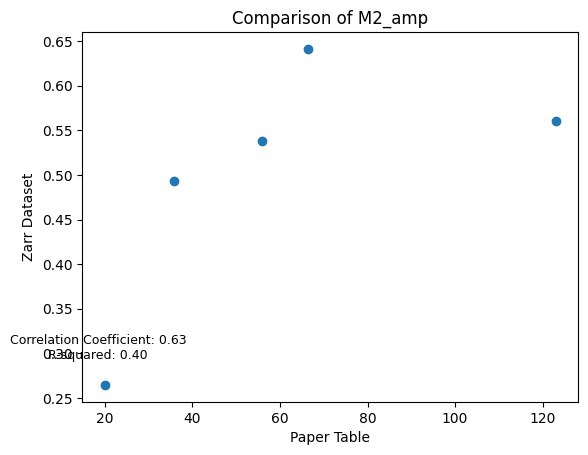

In [8]:
def plot_scatter(x, y, title, xlabel, ylabel):
    plt.scatter(x, y)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    corr_coef = np.corrcoef(x, y)[0, 1]
    r_squared = corr_coef ** 2
    plt.figtext(0.15, 0.2, f'Correlation Coefficient: {corr_coef:.2f}\nR-squared: {r_squared:.2f}', fontsize=9, ha='center')
    plt.show()

# Example for M2_amp
plot_scatter(paper_df["M2_amp"], zarr_df["M2_amp"], "Comparison of M2_amp", "Paper Table", "Zarr Dataset")


In [9]:
def plot_scatter_combined(paper_df, zarr_df, constituents, type):
    # Define a list of distinct colors (more can be added if needed)
    colors = ['r', 'g', 'b', 'y', 'm', 'c']
    
    # Check if provided constituents and colors match
    if len(constituents) > len(colors):
        raise ValueError("Not enough colors defined for the number of constituents.")
    
    plt.figure(figsize=(10, 8))
    
    for i, constituent in enumerate(constituents):
        x = paper_df[f"{constituent}_{type}"]
        y = zarr_df[f"{constituent}_{type}"]
        x = np.nan_to_num(x)
        y = np.nan_to_num(y)

        # Calculate statistics for each constituent
        corr_coef = np.corrcoef(x, y)[0, 1]
        r_squared = corr_coef ** 2
        label = f"{constituent} (Correlation Coefficient: {corr_coef:.2f}, R-squared: {r_squared:.2f})"
        
        # Scatter plot with unique color and label
        plt.scatter(x, y, color=colors[i], label=label)
    
    plt.title(f"Comparison of {type.upper()} between Paper Table and Zarr Dataset")
    plt.xlabel("Paper Table Values")
    plt.ylabel("Zarr Dataset Values")
    plt.legend()
    plt.show()

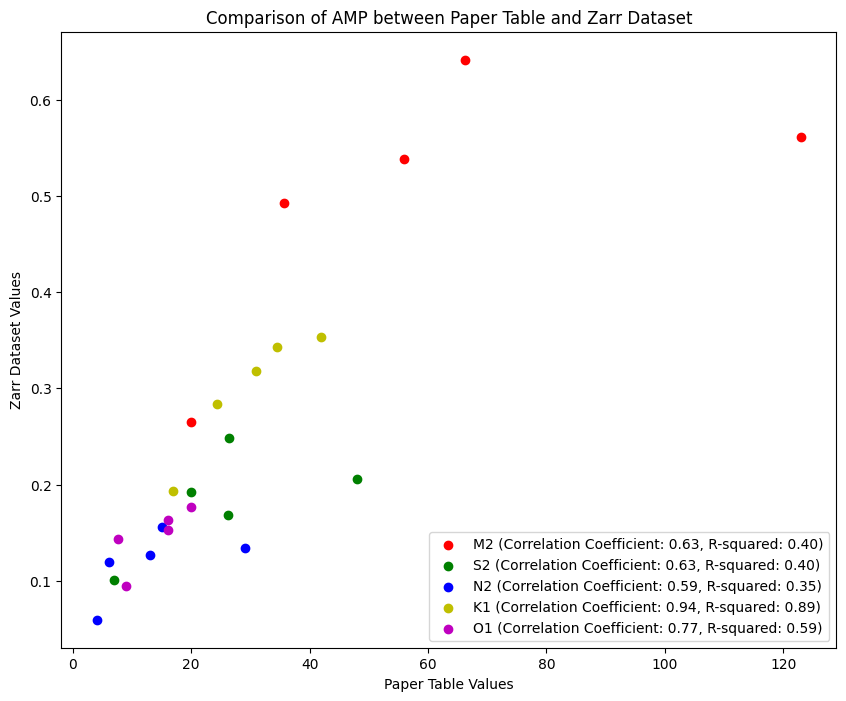

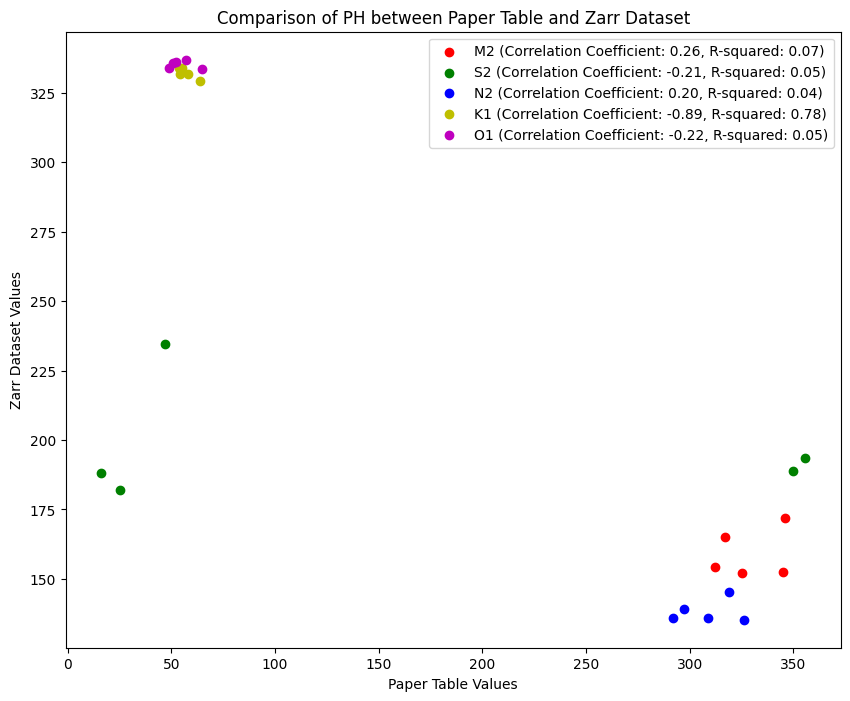

In [10]:
# To use the function
constituents = ["M2", "S2", "N2", "K1", "O1"]

# For amplitude comparison
plot_scatter_combined(paper_df, zarr_df, constituents, "amp")

# For phase comparison
plot_scatter_combined(paper_df, zarr_df, constituents, "ph")

In [11]:
# Convert D and M format to Decimal
def convert_dm_to_decimal(dm_string):
    degree, minute = dm_string.split('D')
    minute = int(minute[:-1])  # Remove 'M' from the minute string
    return int(degree) + minute/60.0



In [12]:
#Incremental inference of boundary forcingfor a three-dimensional tidal model: tides in the Taiwan Strait
#constituents = ["M2", "S2", "N2", "K1", "O1"]
raw_data = {
    "Station": ["Matsu", "Wuchou", "Kinmen", "Taipower1", "Tamsuei", "Hsinchu", "Taichung", "Budai", "Dongee", "Kaohsiung", "Taipower3"],
    "Lat": ["26D10M", "24D59M", "24D24M", "25D18M", "25D11M", "24D51M", "24D20M", "23D23M", "23D15M", "22D37M", "21D57M"],
    "Lon": ["119D57M", "119D27M", "118D25M", "121D36M", "121D24M", "120D55M", "120D33M", "120D09M", "119D40M", "120D17M", "120D45M"],
    "O1_amp": [0.25, 0.25, 0.27, 0.18, 0.18, 0.20, 0.20, 0.19, 0.19, 0.16, 0.20],
    "O1_ph": [88, 112, 124, 92, 97, 106, 115, 126, 125, 129, 105],
    "K1_amp": [0.31, 0.39, 0.33, 0.21, 0.20, 0.23, 0.24, 0.21, 0.20, 0.18, 0.22],
    "K1_ph": [120, 147, 157, 116, 126, 134, 145, 161, 159, 167, 134],
    "N2_amp": [0.40, 0.35, 0.31, 0.10, 0.20, 0.30, 0.33, 0.12, 0.09, 0.04, 0.05],
    "N2_ph": [42, 56, 91, 45, 61, 64, 67, 55, 53, 333, 309],
    "M2_amp": [2.10, 2.05, 1.70, 0.47, 0.99, 1.61, 1.73, 0.63, 0.50, 0.18, 0.26],
    "M2_ph": [64, 89, 112, 73, 80, 85, 90, 75, 79, 351, 312],
    "S2_amp": [0.66, 0.55, 0.49, 0.12, 0.30, 0.47, 0.50, 0.16, 0.10, 0.07, 0.11],
    "S2_ph": [96, 126, 152, 92, 112, 118, 123, 107, 112, 353, 323]
}

# Applying the conversion function to the Lat and Lon columns
raw_data["Latitude"] = [convert_dm_to_decimal(lat) for lat in raw_data["Lat"]]
raw_data["Longitude"] = [convert_dm_to_decimal(lon) for lon in raw_data["Lon"]]

# Removing the old Lat and Lon columns
del raw_data["Lat"]
del raw_data["Lon"]

# Reformatting the dictionary to match the structure of paper_df
data = {
    "Location": raw_data["Station"],
    "Latitude": raw_data["Latitude"],
    "Longitude": raw_data["Longitude"],
    "O1_amp": raw_data["O1_amp"],
    "O1_ph": raw_data["O1_ph"],
    "K1_amp": raw_data["K1_amp"],
    "K1_ph": raw_data["K1_ph"],
    "N2_amp": raw_data["N2_amp"],
    "N2_ph": raw_data["N2_ph"],
    "M2_amp": raw_data["M2_amp"],
    "M2_ph": raw_data["M2_ph"],
    "S2_amp": raw_data["S2_amp"],
    "S2_ph": raw_data["S2_ph"]
}

paper2_df = pd.DataFrame(data)
print(paper2_df)


     Location   Latitude   Longitude  O1_amp  O1_ph  K1_amp  K1_ph  N2_amp  \
0       Matsu  26.166667  119.950000    0.25     88    0.31    120    0.40   
1      Wuchou  24.983333  119.450000    0.25    112    0.39    147    0.35   
2      Kinmen  24.400000  118.416667    0.27    124    0.33    157    0.31   
3   Taipower1  25.300000  121.600000    0.18     92    0.21    116    0.10   
4     Tamsuei  25.183333  121.400000    0.18     97    0.20    126    0.20   
5     Hsinchu  24.850000  120.916667    0.20    106    0.23    134    0.30   
6    Taichung  24.333333  120.550000    0.20    115    0.24    145    0.33   
7       Budai  23.383333  120.150000    0.19    126    0.21    161    0.12   
8      Dongee  23.250000  119.666667    0.19    125    0.20    159    0.09   
9   Kaohsiung  22.616667  120.283333    0.16    129    0.18    167    0.04   
10  Taipower3  21.950000  120.750000    0.20    105    0.22    134    0.05   

    N2_ph  M2_amp  M2_ph  S2_amp  S2_ph  
0      42    2.10    

In [13]:
zarr2_df = paper2_df.apply(lambda row: extract_from_zarr(row['Longitude'], row['Latitude'], dz), axis=1, result_type='expand')
print(zarr2_df)

      M2_amp       M2_ph    S2_amp       S2_ph    N2_amp       N2_ph  \
0   2.094973   66.212455  0.659831   96.177171  0.389616   44.896015   
1   2.163601   88.649312  0.601295  129.195542  0.389298   70.960003   
2   1.713754  107.768869  0.486625  157.017853  0.332024   90.690275   
3        NaN         NaN       NaN         NaN       NaN         NaN   
4   0.948773   80.964584  0.240169  110.472279  0.180624   57.893742   
5   1.525808   84.999355  0.437120  118.265245  0.305011   63.939006   
6        NaN         NaN       NaN         NaN       NaN         NaN   
7   0.635852   78.018526  0.146185  110.418423  0.134469   42.588968   
8   0.520219   84.705855  0.100603  127.325518  0.098813   54.057887   
9   0.188693  345.890112  0.068447  348.197565  0.046519  334.536655   
10  0.280189  317.024764  0.112699  333.662312  0.058258  309.427804   

      K1_amp       K1_ph    O1_amp       O1_ph  
0   0.308974  119.468861  0.250072   91.374831  
1   0.300375  140.267702  0.257099  1

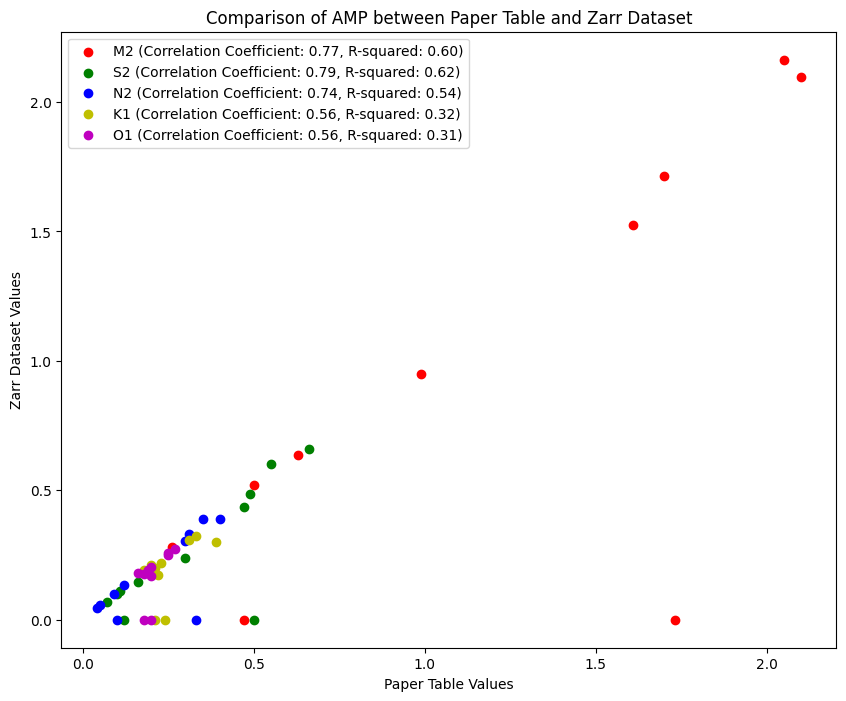

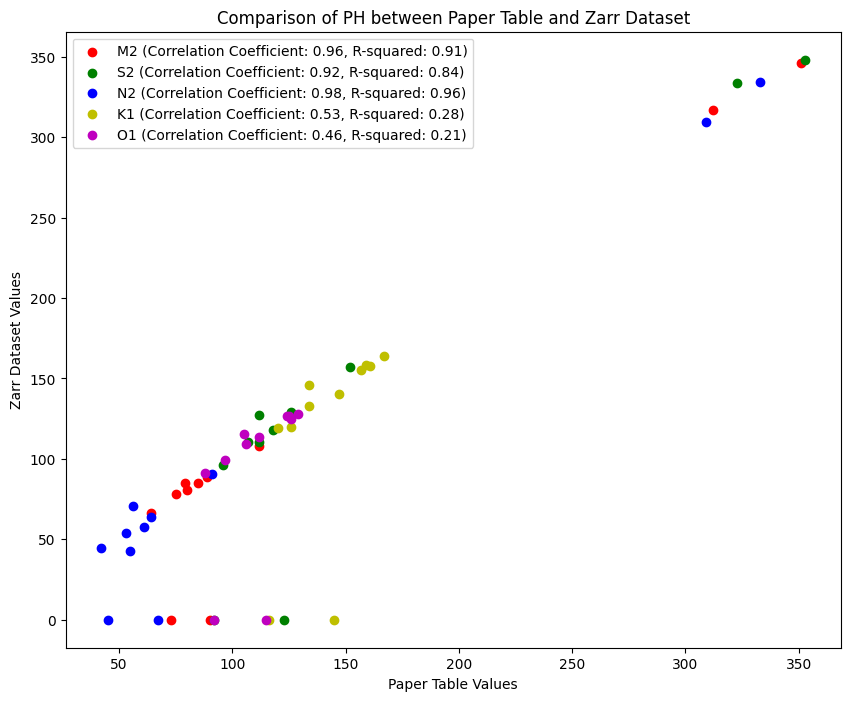

In [14]:
# For amplitude comparison
plot_scatter_combined(paper2_df, zarr2_df, constituents, "amp")

# For phase comparison
plot_scatter_combined(paper2_df, zarr2_df, constituents, "ph")

In [42]:
# Create a DataFrame for the u, v values
data = {
    "Constituent": ["M2", "S2", "N2", "K1", "O1"],
    "Mumbai_u": [13.34, 5.58, 3.77, 6.02, 2.4],
    "Mumbai_v": [5.71, 2.55, 1.69, 3.81, 1.68],
    "Jaigarh_u": [17.58, 7.15, 4.37, 4.84, 3.28],
    "Jaigarh_v": [2.85, 1.40, 0.77, 1.83, 1.20],
    "Goa_u": [5.01, 1.81, 1.21, 1.91, 0.96],
    "Goa_v": [2.36, 1.33, 0.48, 1.08, 0.49],
    "Bhatkal_u": [4.11, 1.79, 0.85, 2.43, 1.03],
    "Bhatkal_v": [3.44, 1.61, 0.62, 3.00, 0.93],
    "Kollam_u": [2.26, 1.23, 0.56, 2.39, 1.21],
    "Kollam_v": [8.73, 3.63, 1.76, 5.22, 3.07]
}
df_uv = pd.DataFrame(data)

# Transpose the DataFrame and reformat it for easier merging
df_uv_t = df_uv.melt(id_vars="Constituent", var_name="Location_UV", value_name="Value")
df_uv_t["Location"] = df_uv_t["Location_UV"].apply(lambda x: x.split("_")[0])
df_uv_t["Type"] = df_uv_t["Location_UV"].apply(lambda x: x.split("_")[1])

df_wide = df_uv_t.pivot_table(index=["Location", "Constituent"], columns="Type", values="Value").reset_index()

# Create a DataFrame for the datetime and location information
data_info = {
    "ADCP": ["M100", "J100", "G100", "B100", "K150"],
    "Location": ["Mumbai", "Jaigarh", "Goa", "Bhatkal", "Kollam"],
    "Latitude": [20.91, 17.15, 15.17, 13.67, 9.00],
    "Longitude": [69.23, 72.08, 73.19, 73.51, 75.96],
    "ADCP_Depth(m)": [79, 92, 90, 97, 154],
    "Water_Depth(m)": [112, 108, 98, 104, 179],
    "Coastal_angle": [20.91, 36.00, 21.40, 16.94, 30.57],
    "Start_date": ["21/Oct/08", "04/Mar/08", "02/Mar/08", "05/Mar/08", "20/Sep/10"],
    "End_date": ["12/Sep/09", "18/Oct/08", "22/Oct/08", "07/Sep/08", "25/Oct/11"]
}
df_info = pd.DataFrame(data_info)

# Merge the two DataFrames on the 'Location' column
df_merged = pd.merge(df_info, df_wide, on="Location")

print(df_merged)

    ADCP Location  Latitude  Longitude  ADCP_Depth(m)  Water_Depth(m)  \
0   M100   Mumbai     20.91      69.23             79             112   
1   M100   Mumbai     20.91      69.23             79             112   
2   M100   Mumbai     20.91      69.23             79             112   
3   M100   Mumbai     20.91      69.23             79             112   
4   M100   Mumbai     20.91      69.23             79             112   
5   J100  Jaigarh     17.15      72.08             92             108   
6   J100  Jaigarh     17.15      72.08             92             108   
7   J100  Jaigarh     17.15      72.08             92             108   
8   J100  Jaigarh     17.15      72.08             92             108   
9   J100  Jaigarh     17.15      72.08             92             108   
10  G100      Goa     15.17      73.19             90              98   
11  G100      Goa     15.17      73.19             90              98   
12  G100      Goa     15.17      73.19             

In [43]:
# Convert start and end date strings to datetime format
df_merged['Start_date'] = pd.to_datetime(df_merged['Start_date'], format='%d/%b/%y')
df_merged['End_date'] = pd.to_datetime(df_merged['End_date'], format='%d/%b/%y')

In [44]:
def get_tide_map_constituent(dz, tide_time,
            constituent=['q1','o1','p1','k1','n2','m2','s1','s2','k2','m4','ms4','mn4','2n2','mf','mm'],    
            format='netcdf', type=['u', 'v']):
    DELTAT = np.zeros_like(tide_time)
    
    # Filter the constituents based on the given input list
    c = dz.coords['constituents'].values
    c_filtered = [c_val for c_val in c if c_val in constituent]
    if len(c_filtered) != len(constituent):
        raise ValueError("Not all input constituents found in the dataset!")
    
    dz_filtered = dz.sel(constituents=c_filtered)
    timelen = len(tide_time)
    tide = {}

    for TYPE in type:
        amp = dz_filtered[TYPE+'_amp'].isel(lon=0, lat=0).values[:]
        ph = dz_filtered[TYPE+'_ph'].isel(lon=0, lat=0).values[:]  # Extract phase values
        amp = np.reshape(amp, (1,len(c_filtered)))
        ph = np.reshape(ph, (1,len(c_filtered)))
        # Calculate complex phase in radians for Euler's
        cph = -1j * ph * np.pi / 180.0
        # Calculate constituent oscillation
        hc = amp * np.exp(cph)
        
        # Mask where values are NA or 0
        mask = np.isnan(hc) | (hc == 0)
        # Convert hc to a masked array
        hc = ma.array(hc, mask=mask)

        tide[TYPE] = np.ma.zeros(timelen)
        for hour in range(timelen):
            TIDE = predict.map(tide_time[hour], hc, c_filtered, deltat=DELTAT[hour], corrections=format)
            MINOR = predict.infer_minor(tide_time[hour], hc, c_filtered, deltat=DELTAT[hour], corrections=format)
            tide[TYPE][hour] = TIDE + MINOR

    return tide


In [45]:
# Assuming some location and corresponding data
loc_filter = df_merged['Location'] == "Mumbai"
start_date, end_date, x, y = df_merged.loc[loc_filter, ['Start_date', 'End_date', 'Longitude', 'Latitude']].iloc[0]
print(start_date, end_date, x, y)
grid_sz=1/30
dsub = dz.sel(lon=slice(x-grid_sz, x+grid_sz), lat=slice(y-grid_sz, y+grid_sz))
ampx1 = dsub['u_amp'].isel(lon=0, lat=0)
#ampx2 = dsub['u_amp'].isel(lon=1, lat=1)
print(dsub)
print(ampx1.values)
#print(ampx2.values)
# tide_time, dtime = get_tide_time(start_date, end_date)
# tides = get_tide_map_constituent(dsub, tide_time, ["m2", "s2", "n2", "k1", "o1"])

2008-10-21 00:00:00 2009-09-12 00:00:00 69.23 20.91
<xarray.Dataset>
Dimensions:       (constituents: 15, lat: 2, lon: 2)
Coordinates:
  * constituents  (constituents) <U3 'q1' 'o1' 'p1' 'k1' ... '2n2' 'mf' 'mm'
  * lat           (lat) float64 20.9 20.93
  * lon           (lon) float64 69.2 69.23
Data variables:
    u_amp         (lat, lon, constituents) float64 dask.array<chunksize=(2, 2, 8), meta=np.ndarray>
    u_ph          (lat, lon, constituents) float64 dask.array<chunksize=(2, 2, 8), meta=np.ndarray>
    v_amp         (lat, lon, constituents) float64 dask.array<chunksize=(2, 2, 8), meta=np.ndarray>
    v_ph          (lat, lon, constituents) float64 dask.array<chunksize=(2, 2, 8), meta=np.ndarray>
    z_amp         (lat, lon, constituents) float64 dask.array<chunksize=(2, 2, 8), meta=np.ndarray>
    z_ph          (lat, lon, constituents) float64 dask.array<chunksize=(2, 2, 8), meta=np.ndarray>
[4.90435098e-02 4.72978953e-01 1.61995587e+00 1.43368441e+00
 5.11955226e-01 1.8368617

In [46]:
def get_tide_constituent(dz, mode="amp",
                         constituent=['q1', 'o1', 'p1', 'k1', 'n2', 'm2', 's1', 's2', 'k2', 'm4', 'ms4', 'mn4', '2n2', 'mf', 'mm'],    
                         type=['u', 'v']):
    # Filter the constituents based on the given input list
    c = dz.coords['constituents'].values
    c_filtered = [c_val for c_val in c if c_val in constituent]
    if len(c_filtered) != len(constituent):
        raise ValueError("Not all input constituents found in the dataset!")
    
    dz_filtered = dz.sel(constituents=c_filtered)
    
    # Dictionary to store the amplitudes
    amplitudes = {}
    phase = {}
    harmonic = {}

    for TYPE in type:
        for const in c_filtered:
            #print(const, dz_filtered[TYPE+'_amp'].sel(constituents=const).values)
            amp = dz_filtered[TYPE+'_amp'].sel(constituents=const).values
            key = f"{const}_{TYPE}"
            amplitudes[key] = amp
            ph = dz_filtered[TYPE+'_ph'].sel(constituents=const).values
            key = f"{const}_{TYPE}"
            phase[key] = ph
            cph = -1j * ph * np.pi / 180.0
            # Calculate constituent oscillation
            hc = amp * np.exp(cph)       
            # Mask where values are NA or 0
            # mask = np.isnan(hc) | (hc == 0)
            # Convert hc to a masked array
            # hc = ma.array(hc, mask=mask)
            harmonic[key] = hc

    if mode == 'amp':
        return amplitudes
    elif mode == 'ph':
        return phase
    return harmonic        

In [47]:
locations = ["Mumbai", "Jaigarh", "Goa", "Bhatkal", "Kollam"]

zarr_results = {}

for loc in locations:
    loc_filter = df_merged['Location'] == loc
    x, y = df_merged.loc[loc_filter, ['Longitude', 'Latitude']].iloc[0]
    dsub = dz.sel(lon=x, lat=y, method='nearest')
    zarr_results[loc] = get_tide_constituent(dsub, 'amp', ["m2", "s2", "n2", "k1", "o1"])

print(zarr_results)

{'Mumbai': {'o1_u': array(0.866353), 'k1_u': array(2.49875053), 'n2_u': array(0.92092326), 'm2_u': array(3.01509778), 's2_u': array(1.83561223), 'o1_v': array(0.70631516), 'k1_v': array(1.86666481), 'n2_v': array(0.77990111), 'm2_v': array(4.9157617), 's2_v': array(1.582369)}, 'Jaigarh': {'o1_u': array(2.28095049), 'k1_u': array(4.83842446), 'n2_u': array(4.62695503), 'm2_u': array(18.15978803), 's2_u': array(7.46267965), 'o1_v': array(1.38096023), 'k1_v': array(3.95624065), 'n2_v': array(3.70815727), 'm2_v': array(13.33098309), 's2_v': array(4.73477126)}, 'Goa': {'o1_u': array(0.43756879), 'k1_u': array(0.87554978), 'n2_u': array(0.97423796), 'm2_u': array(3.4334462), 's2_u': array(1.54156087), 'o1_v': array(0.61519926), 'k1_v': array(1.69926973), 'n2_v': array(0.97958544), 'm2_v': array(4.18339239), 's2_v': array(1.47590513)}, 'Bhatkal': {'o1_u': array(0.65044061), 'k1_u': array(1.14341503), 'n2_u': array(1.03269954), 'm2_u': array(4.18596265), 's2_u': array(1.64239631), 'o1_v': arra

In [48]:
data = {
    "Constituent": ["M2", "S2", "N2", "K1", "O1"],
    "Mumbai_u": [13.34, 5.58, 3.77, 6.02, 2.4],
    "Mumbai_v": [5.71, 2.55, 1.69, 3.81, 1.68],
    "Jaigarh_u": [17.58, 7.15, 4.37, 4.84, 3.28],
    "Jaigarh_v": [2.85, 1.40, 0.77, 1.83, 1.20],
    "Goa_u": [5.01, 1.81, 1.21, 1.91, 0.96],
    "Goa_v": [2.36, 1.33, 0.48, 1.08, 0.49],
    "Bhatkal_u": [4.11, 1.79, 0.85, 2.43, 1.03],
    "Bhatkal_v": [3.44, 1.61, 0.62, 3.00, 0.93],
    "Kollam_u": [2.26, 1.23, 0.56, 2.39, 1.21],
    "Kollam_v": [8.73, 3.63, 1.76, 5.22, 3.07]
}

In [49]:
# Convert paper_data to paper_df
# paper_df = pd.DataFrame.from_dict(data).set_index('Constituent').transpose()
intermediate_df = pd.DataFrame.from_dict(data)

# Melt the DataFrame
melted_df = intermediate_df.melt(id_vars=["Constituent"], 
                                 value_vars=[col for col in intermediate_df.columns if col != "Constituent"],
                                 var_name="Location_Type", value_name="Value")

# Split Location and Type
location_type_df = melted_df['Location_Type'].str.split('_', expand=True)
melted_df['Location'] = location_type_df[0]
melted_df['Type'] = location_type_df[1]
melted_df.drop(columns=["Location_Type"], inplace=True)
#print(melted_df)

# Pivot table to desired format
paper_df = melted_df.pivot_table(index='Location', columns=['Constituent', 'Type'], values='Value').reset_index()
#print(paper_df)
#print(paper_df.columns[1:])
paper_df.columns = ['_'.join(col).strip() for col in paper_df.columns.values]
#print(paper_df)
paper_df.set_index('Location_', inplace=True)
#paper_df.drop(columns=['Location_'], inplace=True)
print(paper_df)


           K1_u  K1_v   M2_u  M2_v  N2_u  N2_v  O1_u  O1_v  S2_u  S2_v
Location_                                                             
Bhatkal    2.43  3.00   4.11  3.44  0.85  0.62  1.03  0.93  1.79  1.61
Goa        1.91  1.08   5.01  2.36  1.21  0.48  0.96  0.49  1.81  1.33
Jaigarh    4.84  1.83  17.58  2.85  4.37  0.77  3.28  1.20  7.15  1.40
Kollam     2.39  5.22   2.26  8.73  0.56  1.76  1.21  3.07  1.23  3.63
Mumbai     6.02  3.81  13.34  5.71  3.77  1.69  2.40  1.68  5.58  2.55


In [50]:
# Convert zarr_results to zarr_df
zarr_data = {}
locations = ["Mumbai", "Jaigarh", "Goa", "Bhatkal", "Kollam"]
types = ["u", "v"]

# Reformat zarr_results
for location in locations:
    for t in types:
        for const in constituents:
            key = f"{const}_{t}"
            if key not in zarr_data:
                zarr_data[key] = []
            
            # Check if the result is a list or array and if so, only append the first value
            result = zarr_results[location][key.lower()]
            #print(result)
            #if isinstance(result, (list, np.ndarray)) and len(result) == 1:
            #    zarr_data[key].append(result[0])
            #else:
            zarr_data[key].append(result)

zarr_df = pd.DataFrame(zarr_data, index=locations)
print(zarr_df)
print(zarr_df.shape)


                       M2_u                S2_u                N2_u  \
Mumbai   3.0150977788282547  1.8356122267685582   0.920923255370993   
Jaigarh   18.15978802594847   7.462679654463443   4.626955030453779   
Goa      3.4334462006960558  1.5415608686194897  0.9742379640371231   
Bhatkal   4.185962648416887  1.6423963143139841  1.0326995382585753   
Kollam    2.404011333626761   1.131794490903756   0.524563710387324   

                       K1_u                O1_u                M2_v  \
Mumbai   2.4987505288694702  0.8663529961622617   4.915761695590247   
Jaigarh   4.838424456580842   2.280950487525389  13.330983085186256   
Goa      0.8755497752320187  0.4375687898781903   4.183392385563347   
Bhatkal   1.143415031332454  0.6504406126319262   7.762782055873925   
Kollam   1.7448199090375587  0.8360832966549298   6.788519131185271   

                       S2_v                N2_v                K1_v  \
Mumbai   1.5823689982406766  0.7799011092001691  1.8666648091770452   
Jaig

In [51]:
paper_df.columns = [col.rstrip('_') if col.endswith('_') else col for col in paper_df.columns]
paper_df = paper_df.reindex(zarr_df.index)
# Check the ordering
print(paper_df)
print(zarr_df)

         K1_u  K1_v   M2_u  M2_v  N2_u  N2_v  O1_u  O1_v  S2_u  S2_v
Mumbai   6.02  3.81  13.34  5.71  3.77  1.69  2.40  1.68  5.58  2.55
Jaigarh  4.84  1.83  17.58  2.85  4.37  0.77  3.28  1.20  7.15  1.40
Goa      1.91  1.08   5.01  2.36  1.21  0.48  0.96  0.49  1.81  1.33
Bhatkal  2.43  3.00   4.11  3.44  0.85  0.62  1.03  0.93  1.79  1.61
Kollam   2.39  5.22   2.26  8.73  0.56  1.76  1.21  3.07  1.23  3.63
                       M2_u                S2_u                N2_u  \
Mumbai   3.0150977788282547  1.8356122267685582   0.920923255370993   
Jaigarh   18.15978802594847   7.462679654463443   4.626955030453779   
Goa      3.4334462006960558  1.5415608686194897  0.9742379640371231   
Bhatkal   4.185962648416887  1.6423963143139841  1.0326995382585753   
Kollam    2.404011333626761   1.131794490903756   0.524563710387324   

                       K1_u                O1_u                M2_v  \
Mumbai   2.4987505288694702  0.8663529961622617   4.915761695590247   
Jaigarh   4.83842

In [52]:
def plot_scatter_uv(paper_df, zarr_df, constituents, type):
    # Define a list of distinct colors (more can be added if needed)
    colors = ['r', 'g', 'b', 'y', 'm', 'c']
    
    # Check if provided constituents and colors match
    if len(constituents) > len(colors):
        raise ValueError("Not enough colors defined for the number of constituents.")
    
    plt.figure(figsize=(10, 8))
    
    for i, constituent in enumerate(constituents):
        x = paper_df[f"{constituent}_{type}"].values
        y = zarr_df[f"{constituent}_{type}"].values
        if isinstance(y, (list, np.ndarray)) and len(y) == 1:
            y = y[0]
        y = y/100.0 # to m/s    
        #print(x,y)

        # Calculate statistics for each constituent
        # corr_coef = np.corrcoef(x, y)[0, 1]
        # r_squared = corr_coef ** 2

        mean_x = np.mean(x)
        mean_y = np.mean(y)
        cov_xy = np.mean((x - mean_x) * (y - mean_y))
        std_x = np.std(x)
        std_y = np.std(y)
        corr_coef = cov_xy / (std_x * std_y)
        r_squared = corr_coef ** 2
        label = f"{constituent} (Correlation Coefficient: {corr_coef:.2f}, R-squared: {r_squared:.2f})"
        
        # Plotting
        #plt.subplot(2, 3, idx)
        #plt.scatter(x, y, label=f"{constituent} (Correlation Coefficient: {corr_coef:.2f}, R-squared: {r_squared:.2f})")
        #plt.xlabel('Paper Data')
        #plt.ylabel('Zarr Data')
        #plt.legend()
    
    #plt.tight_layout()
    #plt.show()

        # Scatter plot with unique color and label
        plt.scatter(x, y, color=colors[i], label=label)
    
    plt.title(f"Comparison of {type.upper()} between Paper Table and Zarr Dataset")
    plt.xlabel("Paper Table Values")
    plt.ylabel("Zarr Dataset Values")
    plt.legend()
    plt.show()
    


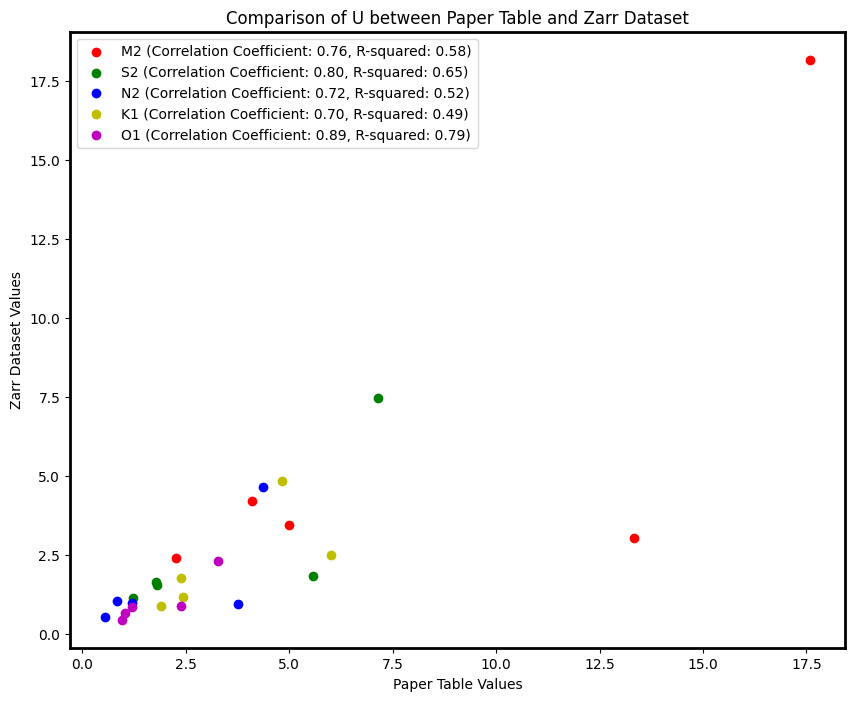

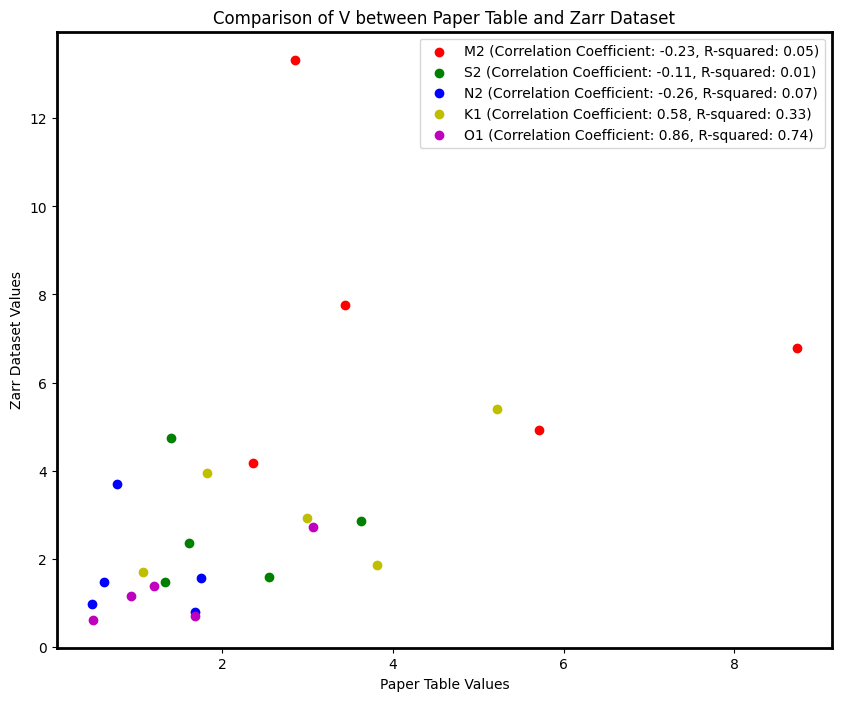

In [44]:
# Now you can call the plotting function
plot_scatter_uv(paper_df, zarr_df, ["M2", "S2", "N2", "K1", "O1"] , 'u')
plot_scatter_uv(paper_df, zarr_df, ["M2", "S2", "N2", "K1", "O1"] , 'v')


In [105]:
#Incremental inference of boundary forcingfor a three-dimensional tidal model: tides in the Taiwan Strait
raw_data3 = {
    "Location": ["WC1", "WC2", "WC3", "WC4", "EWC", "PHC"],
    "Lat": ["24D59M", "24D50M", "24D39M", "24D28M", "25D00M", "23D51M"],
    "Lon": ["119D29M", "119D48M", "120D08M", "120D28M", "120D08M", "119D52M"],
    "K1_Ma": [0.091, 0.047, 0.031, 0.015, 0.113, 0.075],
    "K1_Mi": [0.001, 0.017, 0.013, 0.000, 0.010, 0.033],
    "K1_O": [29, 38, 31, 49, 40, 69],
    "K1_G": [305, 238, 223, 213, 288, 338],
    "M2_Ma": [0.295, 0.221, 0.127, 0.053, 0.310, 0.693],
    "M2_Mi": [0.065, 0.105, 0.068, .010, 0.110, 0.060],
    "M2_O": [31, 37, 32, 48, 25, 67],
    "M2_G": [264, 252, 233, 224, 214, 348]
}

# Mapping from abbreviation to full location name
abbr_to_location = {
    "MT": "Matsu",
    "WC": "Wuchou",
    "KM": "Kinmen",
    "P1": "Taipower1",
    "TS": "Tamsuei",
    "HC": "Hsinchu",
    "TC": "Taichung",
    "BD": "Budai",
    "DG": "Dongee",
    "KS": "Kaohsiung",
    "P3": "Taipower3"
}

# Convert Station abbreviation to Location and Lat/Lon to Decimal
# raw_data3["Location"] = [abbr_to_location[station[:-1]] for station in raw_data3["Station"]]                       
raw_data3["Latitude"] = [convert_dm_to_decimal(lat) for lat in raw_data3["Lat"]]
raw_data3["Longitude"] = [convert_dm_to_decimal(lon) for lon in raw_data3["Lon"]]

# Delete unused columns
# del raw_data3["Station"]
del raw_data3["Lat"]
del raw_data3["Lon"]

paper3_df = pd.DataFrame(raw_data3)
print(paper3_df)


  Location  K1_Ma  K1_Mi  K1_O  K1_G  M2_Ma  M2_Mi  M2_O  M2_G   Latitude  \
0      WC1  0.091  0.001    29   305  0.295  0.065    31   264  24.983333   
1      WC2  0.047  0.017    38   238  0.221  0.105    37   252  24.833333   
2      WC3  0.031  0.013    31   223  0.127  0.068    32   233  24.650000   
3      WC4  0.015  0.000    49   213  0.053  0.010    48   224  24.466667   
4      EWC  0.113  0.010    40   288  0.310  0.110    25   214  25.000000   
5      PHC  0.075  0.033    69   338  0.693  0.060    67   348  23.850000   

    Longitude  
0  119.483333  
1  119.800000  
2  120.133333  
3  120.466667  
4  120.133333  
5  119.866667  


In [56]:
# Initialize a dictionary to store zarr results for each location
zarr_results = {}

# Get zarr results for each location in paper3_df
locations = paper3_df['Location'].unique()
for loc in locations:
    loc_filter = paper3_df['Location'] == loc
    x, y = paper3_df.loc[loc_filter, ['Longitude', 'Latitude']].iloc[0]
    dsub = dz.sel(lon=x, lat=y, method='nearest')
    zarr_results[loc] = get_tide_constituent(dsub, 'harmonic', ["k1", "m2"])

print(zarr_results)

{'WC1': {'k1_u': (-0.07829683240021822+6.576360720527782j), 'm2_u': (-9.686285722533379+7.698417928552914j), 'k1_v': (1.178354513502202+2.364822723229435j), 'm2_v': (28.20428632886009-1.3893149609926463j)}, 'WC2': {'k1_u': (1.0024994834624936+5.928887082100272j), 'm2_u': (-4.375603987083659+6.6471424069256795j), 'k1_v': (1.3533637038606707+4.20086078285452j), 'm2_v': (11.8207463659544-0.18769223158173834j)}, 'WC3': {'k1_u': (0.9730838576648441+4.665125221634089j), 'm2_u': (-1.5880765111066386+3.4911866221236236j), 'k1_v': (1.161684969221073+4.120416291208649j), 'm2_v': (7.852614413199788-1.7225343398990736j)}, 'WC4': {'k1_u': (0.6097605725839664+3.064693800649206j), 'm2_u': (2.177587706701116+2.8404187047905842j), 'k1_v': (0.8959159402274987+4.362011323895039j), 'm2_v': (2.921889925395493+3.6132558862631714j)}, 'EWC': {'k1_u': (0.034923747880417855+6.099916018951096j), 'm2_u': (-17.843212479494916-0.925343515871941j), 'k1_v': (0.021851504078483977+4.78650991273983j), 'm2_v': (-2.325353

In [57]:
# Evaluate zarr_results to calculate tidal ellipse parameters
major_list = []
minor_list = []
inclination_list = []
lon_list = []
lat_list = []

for loc, amplitudes in zarr_results.items():
    k1_u = amplitudes["k1_u"]/100 #to m/s
    k1_v = amplitudes["k1_v"]/100
    major, minor, inclination, phase = tidal_ellipse(np.atleast_1d(k1_u), np.atleast_1d(k1_v)) #calculate_ellipse_parameters(k1_u, k1_v)
    #print(major, minor, inclination, phase, k1_u, k1_v)
    major_list.append(major[0])
    minor_list.append(minor[0])
    inclination_list.append(inclination[0])
    
    loc_filter = paper3_df['Location'] == loc
    lon, lat = paper3_df.loc[loc_filter, ['Longitude', 'Latitude']].iloc[0]
    lon_list.append(lon)
    lat_list.append(lat)

print(major_list, minor_list)
print(inclination_list)

[0.06996386604356104, 0.07441305371822576, 0.06402275533935817, 0.05440010544493782, 0.07753794597343118, 0.04633476733035087] [0.011340771907786328, 0.005123536296104993, 0.0022021783695481273, 0.000157950990607926, -4.3682515996401605e-05, 0.002247281570977269]
[20.221950004701682, 36.19229879250122, 41.92718106050492, 54.942424854297485, 38.120558934602144, 89.51054739270094]


In [58]:
def calculate_ellipse(u, v, mode="radian"):
    """
    Calculate tidal ellipse parameters.

    Parameters:
    - u: Real component of complex amplitude.
    - v: Imaginary component of complex amplitude.
    - mode: "radian" or "degree". Determines the unit for the inclination and phase.

    Returns:
    - major: Major axis of the tidal ellipse.
    - minor: Minor axis of the tidal ellipse.
    - inclination: Inclination of the tidal ellipse.
    - phase: Phase of the tidal ellipse.
    """
    # Major and minor axis
    U = u + 1j * v
    V = u - 1j * v

    major = np.abs(U)
    minor = np.abs(V)

    # Inclination
    inclination = np.angle(U) * 0.5
    if np.isscalar(inclination):
        inclination = inclination if inclination >= 0 else inclination + np.pi
    else:
        inclination[inclination < 0] += np.pi

    if mode == "degree":
        inclination = np.degrees(inclination)

    # Phase of maximum velocity
    phase = np.angle(-V)
    if mode == "degree":
        phase = np.degrees(phase)
    # Ensure phase is within [0, 2pi] or [0, 360]
    phase %= (2 * np.pi if mode == "radian" else 360)

    return major, minor, inclination, phase

# Example:
u, v = 1.0, 0.5
print(calculate_ellipse(u, v, mode="degree"))


(1.118033988749895, 1.118033988749895, 13.282525588538995, 153.434948822922)


In [59]:
# Evaluate zarr_results to calculate tidal ellipse parameters
major_list = []
minor_list = []
inclination_list = []
lon_list = []
lat_list = []

for loc, amplitudes in zarr_results.items():
    k1_u = amplitudes["k1_u"]/100 #to m/s
    k1_v = amplitudes["k1_v"]/100
    #major, minor, inclination, phase = tidal_ellipse(np.atleast_1d(k1_u), np.atleast_1d(k1_v)) #calculate_ellipse_parameters(k1_u, k1_v)
    major, minor, inclination, phase = calculate_ellipse(k1_u, k1_v, mode="degree")    
    #print(major, minor, inclination, phase, k1_u, k1_v)
    major_list.append(major)
    minor_list.append(minor)
    inclination_list.append(inclination)
    
    loc_filter = paper3_df['Location'] == loc
    lon, lat = paper3_df.loc[loc_filter, ['Longitude', 'Latitude']].iloc[0]
    lon_list.append(lon)
    lat_list.append(lat)

print(major_list, minor_list)
print(inclination_list)

[0.08130463795134737, 0.07953659001433078, 0.06622493370890631, 0.054558056435545746, 0.07749426345743478, 0.04858204890132814] [0.05862309413577471, 0.06928951742212078, 0.06182057696981004, 0.0542421544543299, 0.07758162848942758, 0.04408748575937361]
[53.74350504651163, 56.8555298826469, 59.18777729904651, 66.72628005924244, 63.90892819073208, 48.06908570580793]


In [60]:
def get_tidal_ellipse(data, constituent, loc_data, unit_conv=1/100):
    major_list = []
    minor_list = []
    inclination_list = []
    phase_list = []
    lon_list = []
    lat_list = []    

    for loc, amplitudes in data.items():
        loc_filter = loc_data['Location'] == loc
        lon, lat = loc_data.loc[loc_filter, ['Longitude', 'Latitude']].iloc[0]
        lon_list.append(lon)
        lat_list.append(lat)
        k_u = amplitudes[f"{constituent}_u"] * unit_conv  # to m/s
        k_v = amplitudes[f"{constituent}_v"] * unit_conv
        major, minor, inclination, phase = tidal_ellipse(np.atleast_1d(k_u), np.atleast_1d(k_v))
        major_list.append(major[0])
        minor_list.append(minor[0])
        inclination_list.append(inclination[0])
        phase_list.append(phase[0])

    return lon_list, lat_list, major_list, minor_list, inclination_list, phase_list

In [61]:
lon_list, lat_list, major_list, minor_list, inclination_list,_ = get_tidal_ellipse(zarr_results, "k1", paper3_df, unit_conv=1/100)

print(major_list, minor_list)
print(inclination_list)
print(lon_list, lat_list)

[0.06996386604356104, 0.07441305371822576, 0.06402275533935817, 0.05440010544493782, 0.07753794597343118, 0.04633476733035087] [0.011340771907786328, 0.005123536296104993, 0.0022021783695481273, 0.000157950990607926, -4.3682515996401605e-05, 0.002247281570977269]
[20.221950004701682, 36.19229879250122, 41.92718106050492, 54.942424854297485, 38.120558934602144, 89.51054739270094]
[119.48333333333333, 119.8, 120.13333333333334, 120.46666666666667, 120.13333333333334, 119.86666666666666] [24.983333333333334, 24.833333333333332, 24.65, 24.466666666666665, 25.0, 23.85]


In [62]:
def plot_multiple_ellipses(lon_list, lat_list, major_list, minor_list, inclination_list, scale_factor=0.01):
    fig, ax = plt.subplots()
    ax.set_aspect('equal', 'box')
    
    for lon, lat, major, minor, inclination in zip(lon_list, lat_list, major_list, minor_list, inclination_list):
        scaled_major = major * scale_factor
        scaled_minor = minor * scale_factor
        
        ellipse = patches.Ellipse((lon, lat), width=2*scaled_major, height=2*scaled_minor, angle=inclination,
                                  fill=False, edgecolor='r', linewidth=2)
        ax.add_patch(ellipse)
    
    ax.set_xlim(min(lon_list) - 0.1, max(lon_list) + 0.1)
    ax.set_ylim(min(lat_list) - 0.1, max(lat_list) + 0.1)

    plt.show()

In [63]:
def plot_ellipses_map(lons, lats, major_axes, minor_axes, inclinations, annotations=None, scale_factor=0.0001, buf=2.5):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_aspect('equal', 'box')
    
    # Create the Basemap object
    lon_min, lon_max, lat_min, lat_max = np.min(lons)-buf, np.max(lons)+buf, np.min(lats)-buf, np.max(lats)+buf

    # Round the min/max to the nearest 5 for setting ticks
    lon_start = int(5 * (lon_min // 5))
    lon_end = int(5 * (lon_max // 5 + 1))

    lat_start = int(5 * (lat_min // 5))
    lat_end = int(5 * (lat_max // 5 + 1))

    m = Basemap(projection='merc', llcrnrlat=lat_min, urcrnrlat=lat_max,
                llcrnrlon=lon_min, urcrnrlon=lon_max, lat_ts=20, ax=ax, resolution='i')

    # Convert x, y to map projection coordinates
    x_map, y_map = m(lons, lats)
    
    # Draw ellipses on the map
    for i, (x, y, major, minor, inclination) in enumerate(zip(x_map, y_map, major_axes, minor_axes, inclinations)):
        scaled_major = major * scale_factor
        scaled_minor = minor * scale_factor
        
        ellipse = patches.Ellipse((x, y), width=2*scaled_major*m.xmax, height=2*scaled_minor*m.ymax, angle=inclination,
                                  fill=False, edgecolor='r', linewidth=2)
        ax.add_patch(ellipse)
        
        # Add annotations if provided
        if annotations is not None and len(annotations) > 0:
            ax.text(x, y, annotations[i], color='grey', fontsize=8, ha='center', va='center')

    # Add coastlines
    m.drawcoastlines()

    # Add ticks for meridians and parallels
    parallels = range(lat_start, lat_end, 5)
    meridians = range(lon_start, lon_end, 5)
    m.drawparallels(parallels, labels=[1, 0, 0, 0], linewidth=0.5, fontsize=10)
    m.drawmeridians(meridians, labels=[0, 0, 0, 1], linewidth=0.5, fontsize=10)

    plt.show()

In [174]:
print(paper3_df['Location'].ravel())
print(paper3_df)

['WC1' 'WC2' 'WC3' 'WC4' 'EWC' 'PHC']
  Location  K1_Ma  K1_Mi  K1_O  K1_G  M2_Ma  M2_Mi  M2_O  M2_G   Latitude  \
0      WC1  0.091  0.001    29   305  0.295  0.065    31   264  24.983333   
1      WC2  0.047  0.017    38   238  0.221  0.105    37   252  24.833333   
2      WC3  0.031  0.013    31   223  0.127  0.068    32   233  24.650000   
3      WC4  0.015  0.000    49   213  0.053  0.010    48   224  24.466667   
4      EWC  0.113  0.010    40   288  0.310  0.110    25   214  25.000000   
5      PHC  0.075  0.033    69   338  0.693  0.060    67   348  23.850000   

    Longitude  
0  119.483333  
1  119.800000  
2  120.133333  
3  120.466667  
4  120.133333  
5  119.866667  


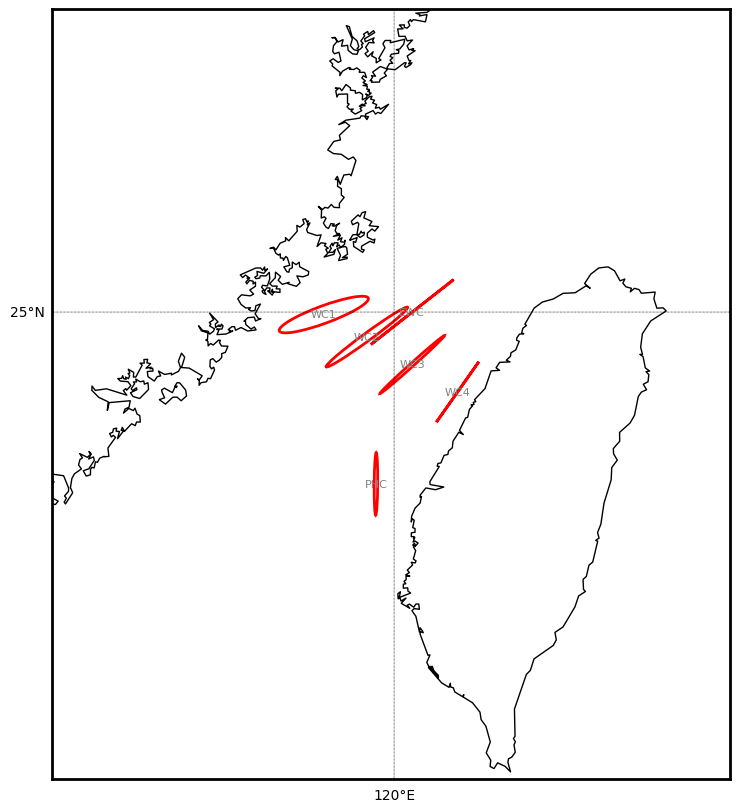

In [68]:
# Plot multiple ellipses for the locations
plot_ellipses_map(lon_list, lat_list, major_list, minor_list, inclination_list, 
                  paper3_df['Location'].ravel(), 1, 2)

In [55]:
lon_list, lat_list, major_m2, minor_m2, inclination_m2, _ = get_tidal_ellipse(zarr_results, "m2", paper3_df, unit_conv=1/100)
print(major_m2, minor_m2, inclination_m2)
print(lon_list, lat_list)


[30.07735874384372, 12.917658327652049, 8.41009899096858, 5.86493988140032, 18.034161529769463, 72.15434237485749] [6.771574711727606, 6.019118605061219, 2.9344988792394306, 0.07352320860234318, -1.9972011667452012, 2.7449930417298916] [110.69334856003377, 117.09506075747872, 108.26089888177307, 52.39816706846944, 7.851316614418806, 83.04268327150183]
[119.48333333333333, 119.8, 120.13333333333334, 120.46666666666667, 120.13333333333334, 119.86666666666666] [24.983333333333334, 24.833333333333332, 24.65, 24.466666666666665, 25.0, 23.85]


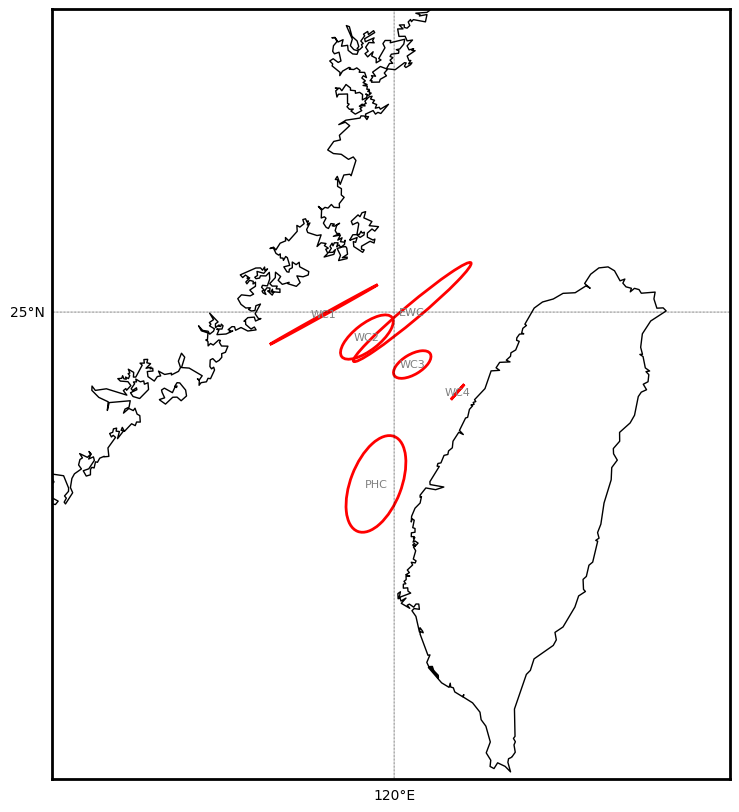

In [66]:
plot_ellipses_map(lon_list, lat_list, 
                  paper3_df['K1_Ma'].ravel(), 
                  paper3_df['K1_Mi'].ravel(), 
                  paper3_df['K1_O'].ravel(),
                  paper3_df['Location'].ravel(), 1, 2)

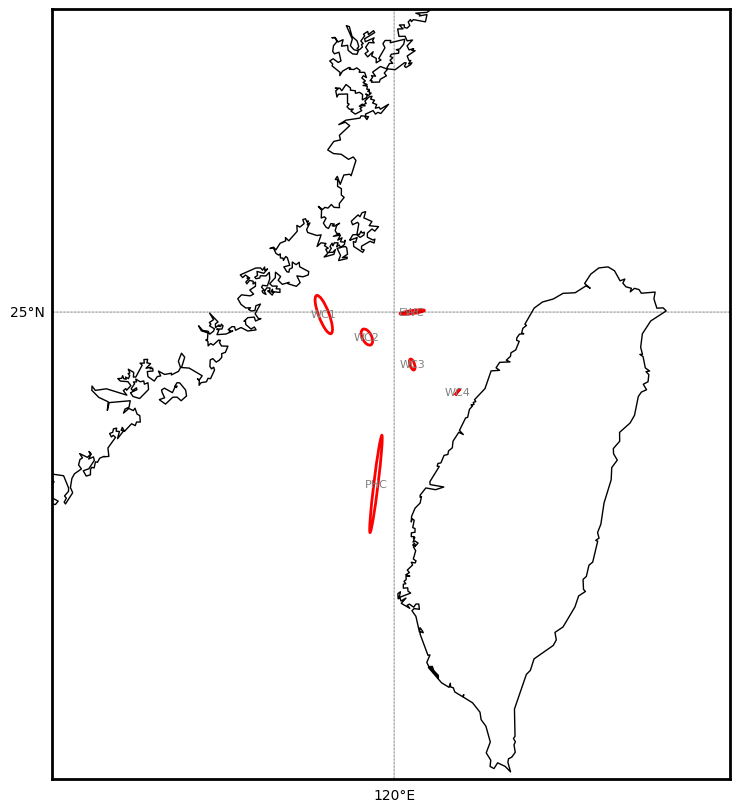

In [103]:
plot_ellipses_map(lon_list, lat_list, major_m2, minor_m2, inclination_m2, 
                  paper3_df['Location'].ravel(), 0.001, 2)

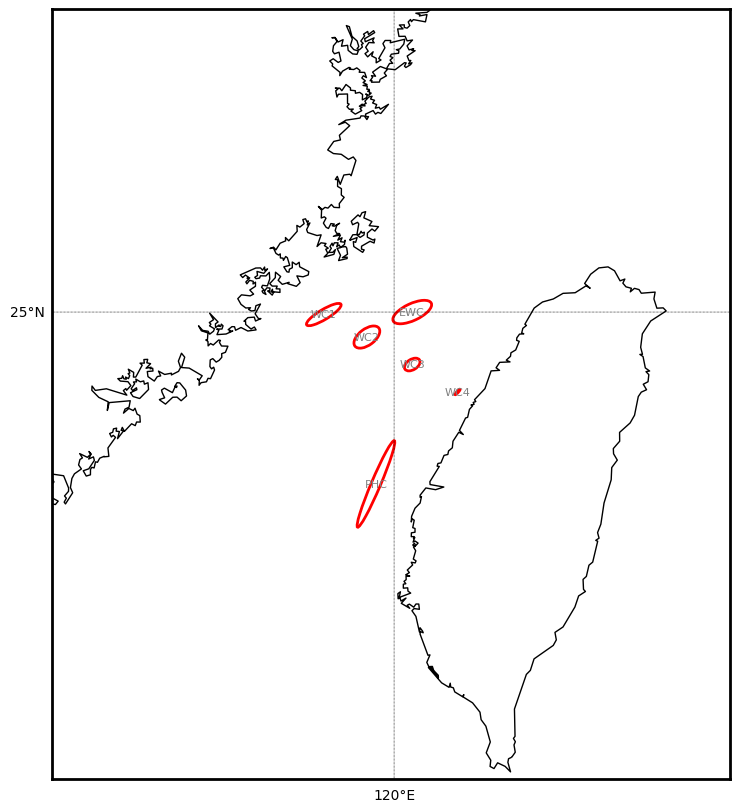

In [67]:
plot_ellipses_map(lon_list, lat_list, 
                  paper3_df['M2_Ma'].ravel(), 
                  paper3_df['M2_Mi'].ravel(), 
                  paper3_df['M2_O'].ravel(),
                  paper3_df['Location'].ravel(), 0.1, 2)

In [4]:
import json

with open('tmp_tide_out40x40_map.json', 'r') as json_file:
    testdata = json.load(json_file)

# Now, 'data' contains the JSON data as a Python dictionary


In [5]:
print(testdata.keys())

dict_keys(['longitude', 'latitude', 'time', 'u', 'v'])


In [16]:
u0 = np.array(testdata["u"])
v0 = np.array(testdata["v"]) 

# Calculate magnitude of the current
mag = np.sqrt(u0**2 + v0**2)
print(mag)

# Normalize the arrows to create a uniform arrow size across the plot
u = u0/mag
v = v0/mag

x = np.array(testdata["longitude"])
y = np.array(testdata["latitude"])

[3.55428526 4.12247468 4.66599504 ... 0.50199886 0.3830272  0.30330056]


In [24]:
import gc
gc.collect()

45670

In [25]:
N = 5 
#lenx = len(x)
#sample = int(np.ceil( lenx / N ))
#print(sample)
print(x[::N].size)
#print(x[::sample])
x1 = x[::N]
y1 = y[::N]
u1 = u[::N]
v1 = v[::N]
mag1 = mag[::N]

7569


In [7]:
#import matplotlib.colors as colors
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

def plot_current_gradients(x, y, u, v, mag, label_time, magmax=50):
    fig, ax = plt.subplots(figsize=(10, 8))

    # Create the Basemap object
    lon_min, lon_max, lat_min, lat_max = np.min(
        x), np.max(x), np.min(y), np.max(y)

    # Round the min/max to the nearest 5 for setting ticks
    lon_start = int(5 * (lon_min // 5))
    # +1 to ensure the upper bound is included
    lon_end = int(5 * (lon_max // 5 + 1))

    lat_start = int(5 * (lat_min // 5))
    # +1 to ensure the upper bound is included
    lat_end = int(5 * (lat_max // 5 + 1))

    m = Basemap(projection='merc', llcrnrlat=lat_min, urcrnrlat=lat_max,
                llcrnrlon=lon_min, urcrnrlon=lon_max, lat_ts=20, ax=ax, resolution='i')

    # Convert x, y to map projection coordinates
    # x_map, y_map = m(x, y)
    # Add coastlines
    m.drawcoastlines()

    # Add ticks for meridians and parallels
    parallels = range(lat_start, lat_end, 5)
    meridians = range(lon_start, lon_end, 5)
    m.drawparallels(parallels, labels=[1, 0, 0, 0], linewidth=0.5, fontsize=10)
    m.drawmeridians(meridians, labels=[0, 0, 0, 1], linewidth=0.5, fontsize=10)

    # Plotting the tidal currents
    vmin_val = 0   # You can set to another value if needed
    vmax_val = magmax

    # Plotting the tidal currents
    valid_indices = mag < vmax_val

    # Make sure you're using the boolean mask to filter ALL arrays
    x = x[valid_indices]
    y = y[valid_indices]
    u = u[valid_indices]
    v = v[valid_indices]
    clipped_mag = mag[valid_indices]

    x_map, y_map = m(x, y)

    # Plotting the tidal currents
    quiver = m.quiver(x_map, y_map, u, v, clipped_mag, angles='xy', scale_units='dots',
                      scale=0.1, pivot='middle', width=0.003, cmap='jet')
    plt.colorbar(quiver, ax=ax, label='Current speed')

    ax.set_title('Tidal Currents at ' + str(label_time))
    ax.set_xlabel('Longitude', labelpad=30)  # Adjust labelpad as needed
    ax.set_ylabel('Latitude', labelpad=30)   # Adjust labelpad as needed

    plt.show()


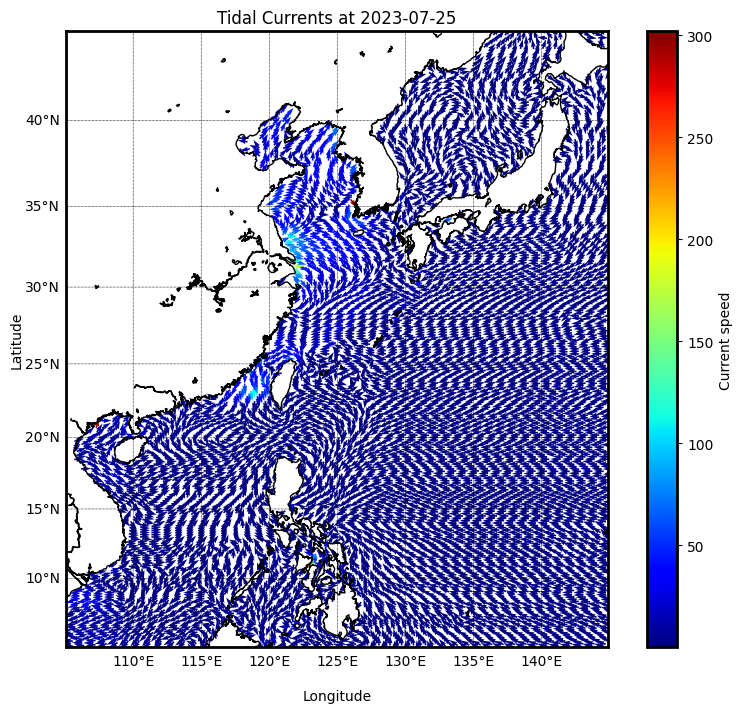

In [26]:
plot_current_gradients(x1, y1, u1, v1, mag1, "2023-07-25", magmax=350)

In [6]:
large_idx = np.where((np.abs(u0)>=50) | (np.abs(v0)>=50))[0]
print(large_idx)
print(mag[1193:1201])
print(x[1193:1201])
print(y[1193:1201])

[1127 1128 1193 1194 1195 1196 1197 1198 1199 1200 1258 1259 1260 1261
 1262 1263 1318 1319 1320 1321 1322 1323 1375 1376 1377 1378 1379 1380
 1381 1382 1383 1437 1438 1439 1501 1560 1561 1562 1624 1684 1738 1800
 1801 1982 2042 2103 2104 2116 2228 2515 3460 3507 3508 3643 3691 3692
 3693 3740 3741 3786 3787 3788 3833 3834 3835 3880]
[58.33411291 78.91169486 88.1822182  90.91889072 93.2165703  77.55720609
 70.25402503 55.90198183]
[118.033332   118.19999866 118.36666533 118.53333199 118.69999866
 118.86666532 119.03333199 119.19999865]
[22.83333424 22.83333424 22.83333424 22.83333424 22.83333424 22.83333424
 22.83333424 22.83333424]


In [7]:
from src.model_utils import get_current_model

In [8]:
#Verify with pyTMD
# Model parameters

tpxo_model_directory = '/home/bioer/python/tide/data_src'
tpxo_model_format = 'netcdf'
tpxo_compressed = False
tpxo_model_name = 'TPXO9-atlas-v5'

tpxo_curr_model = get_current_model(tpxo_model_name, tpxo_model_directory, tpxo_model_format, tpxo_compressed)
print(tpxo_curr_model)
print(tpxo_curr_model.grid_file)
print(tpxo_curr_model.model_file)

/home/bioer/python/tide/data_src/TPXO9_atlas_v5/grid_tpxo9_atlas_30_v5.nc
{'u': [PosixPath('/home/bioer/python/tide/data_src/TPXO9_atlas_v5/u_q1_tpxo9_atlas_30_v5.nc'), PosixPath('/home/bioer/python/tide/data_src/TPXO9_atlas_v5/u_o1_tpxo9_atlas_30_v5.nc'), PosixPath('/home/bioer/python/tide/data_src/TPXO9_atlas_v5/u_p1_tpxo9_atlas_30_v5.nc'), PosixPath('/home/bioer/python/tide/data_src/TPXO9_atlas_v5/u_k1_tpxo9_atlas_30_v5.nc'), PosixPath('/home/bioer/python/tide/data_src/TPXO9_atlas_v5/u_n2_tpxo9_atlas_30_v5.nc'), PosixPath('/home/bioer/python/tide/data_src/TPXO9_atlas_v5/u_m2_tpxo9_atlas_30_v5.nc'), PosixPath('/home/bioer/python/tide/data_src/TPXO9_atlas_v5/u_s1_tpxo9_atlas_30_v5.nc'), PosixPath('/home/bioer/python/tide/data_src/TPXO9_atlas_v5/u_s2_tpxo9_atlas_30_v5.nc'), PosixPath('/home/bioer/python/tide/data_src/TPXO9_atlas_v5/u_k2_tpxo9_atlas_30_v5.nc'), PosixPath('/home/bioer/python/tide/data_src/TPXO9_atlas_v5/u_m4_tpxo9_atlas_30_v5.nc'), PosixPath('/home/bioer/python/tide/data

In [9]:
from pyTMD.io import ATLAS


In [ ]:
ampu, phu, D, c = ATLAS.extract_constants(
        x[1193:1201], y[1193:1201],
        tpxo_curr_model.grid_file,
        tpxo_curr_model.model_file['u'], type='u', method='spline',
        scale=tpxo_curr_model.scale, compressed=tpxo_curr_model.compressed
    )
print(ampu)
print(phu)

In [11]:
ampu_ex, phu_ex, D, c = ATLAS.extract_constants(
        x[1193:1201], y[1193:1201],
        tpxo_curr_model.grid_file,
        tpxo_curr_model.model_file['u'], type='u', method='spline',
        scale=tpxo_curr_model.scale, compressed=tpxo_curr_model.compressed,
        extrapolate = True
    )
print(ampu_ex)
print(phu_ex)

[[29.881492163964104 58.07633346386415 259.1972825702797
  368.21261192563594 633.5693187790492 367.0614087475642
  9.981625336558242 334.24654747274866 377.5816565704873
  461.38743839136697 157.4428182506624 24.65747654388396
  107.1217650051865 0.05104605427265156 0.02552302713632578]
 [19.697193929500383 54.71458070690217 200.0908308626714
  322.3860453796848 459.1796583918191 631.0179159397288
  6.9485025775698785 139.8415334365245 284.440625922423 316.7649343470234
  104.61402131637266 15.692145496330065 78.83979816643051
  0.03725939539402073 0.03725939539402073]
 [24.370074576518196 127.33080554347842 244.77723236120997
  443.3644159996069 445.3105493160499 1597.4853487674875
  6.358424094808375 90.02628300050043 301.0454173652289 322.7555993168348
  98.44627103012623 20.222497969482713 80.37507257559062
  0.09375595799620584 0.05929647241039838]
 [30.30233031137297 181.42360666569283 284.2690986835377
  525.8418851973458 448.9138916689051 2390.8454156028542
  6.491621442112269

In [45]:
print(c)
print(ampu.shape)
print(phu.shape)
#ampu.data

['q1', 'o1', 'p1', 'k1', 'n2', 'm2', 's1', 's2', 'k2', 'm4', 'ms4', 'mn4', '2n2', 'mf', 'mm']
(8, 15)
(8, 15)


In [46]:
ampv, phv, D, c = ATLAS.extract_constants(
        x[1193:1201], y[1193:1201],
        tpxo_curr_model.grid_file,
        tpxo_curr_model.model_file['v'], type='v', method='spline',
        scale=tpxo_curr_model.scale, compressed=tpxo_curr_model.compressed,
    )
print(ampv)
print(phv)

[[89.6397813512439 654.2118832987888 172.8051433540304 838.5600279144521
  1562.6317437720022 7704.553983277972 19.637247793378982
  2047.0537393926495 702.4463473452154 154.78976209869728
  65.43405906508863 37.35952563626636 220.53779946219336
  0.5149261906569044 0.2320287799585873]
 [117.28850527730307 759.7174528994447 199.9311941399997
  966.9111463277958 1736.7830343704609 9221.883863125882
  24.462717215830136 2286.7236942902587 787.7624821735349
  89.73754008806276 55.645326870948054 20.77173668847173
  248.50040012711818 0.7198561297919933 0.32277717585094173]
 [108.9381670367221 767.2872179038437 206.35202146958426
  949.6612878450277 1845.0294280066812 10523.569140772244
  23.420090159054098 2404.201092013768 848.0258569362902
  96.22079954907744 79.45571961575102 25.985370417623454
  266.19425455016227 0.6771759663027019 0.3168054296646382]
 [95.2293878839071 743.9764423566777 203.08426301827183 908.240843899047
  1782.7537485987991 10933.862860486342 20.995804830263406
  

In [12]:
ampv_ex, phv_ex, D, c = ATLAS.extract_constants(
        x[1193:1201], y[1193:1201],
        tpxo_curr_model.grid_file,
        tpxo_curr_model.model_file['v'], type='v', method='spline',
        scale=tpxo_curr_model.scale, compressed=tpxo_curr_model.compressed,
        extrapolate=True
    )
print(ampv_ex)
print(phv_ex)

[[89.6397813512439 654.2118832987888 172.8051433540304 838.5600279144521
  1562.6317437720022 7704.553983277972 19.637247793378982
  2047.0537393926495 702.4463473452154 154.78976209869728
  65.43405906508863 37.35952563626636 220.53779946219336
  0.5149261906569044 0.2320287799585873]
 [117.28850527730307 759.7174528994447 199.9311941399997
  966.9111463277958 1736.7830343704609 9221.883863125882
  24.462717215830136 2286.7236942902587 787.7624821735349
  89.73754008806276 55.645326870948054 20.77173668847173
  248.50040012711818 0.7198561297919933 0.32277717585094173]
 [108.9381670367221 767.2872179038437 206.35202146958426
  949.6612878450277 1845.0294280066812 10523.569140772244
  23.420090159054098 2404.201092013768 848.0258569362902
  96.22079954907744 79.45571961575102 25.985370417623454
  266.19425455016227 0.6771759663027019 0.3168054296646382]
 [95.2293878839071 743.9764423566777 203.08426301827183 908.240843899047
  1782.7537485987991 10933.862860486342 20.995804830263406
  

In [13]:
from src.model_utils import get_tide_time
start_date = datetime(2023, 7, 25)
end_date = datetime(2023, 7, 28)
tide_time, dtime = get_tide_time(start_date, end_date)

In [ ]:
# cannot work
#from src.model_utils import get_tide_series
#upy = get_tide_series(ampu.data.reshape((8, 1, -1)), 
#                      phu.data.reshape((8, 1, -1)), 
#                      c, #np.array(['q1','o1','p1','k1','n2','m2','s1','s2','k2','m4','ms4','mn4','2n2','mf','mm']), 
#                      tide_time[0:1], format="netcdf", unit="cm", drop_mask=True)
#print(upy)
#print(u0)

In [14]:
print(tide_time[0:1])
DELTAT = np.zeros_like(tide_time[0:1])


[11528.]


In [15]:
from pyTMD import predict

In [51]:
#from pyTMD import predict
drop_dim = True
ny = 8
nx = 8
format = 'netcdf'
if True:
    timelen = len(tide_time[0:1])
    tide = {}

    for TYPE in ['u', 'v']:
        if TYPE == 'u':
            amp = ampu
            ph = phu
        else:
            amp = ampv
            ph = phv

        shpx = amp.shape
        ampx = amp.reshape((shpx[0] * 1, shpx[1]))
        phx = ph.reshape((shpx[0] * 1, shpx[1]))
        # calculate complex phase in radians for Euler's
        cph = -1j * phx * np.pi / 180.0
        # calculate constituent oscillation
        hc = ampx * np.exp(cph)
        # Create a mask where values are NA or 0
        mask = np.isnan(hc) | (hc == 0)
        # Convert hc to a masked array
        hc = ma.array(hc, mask=mask)  # mask=False

        if drop_dim:
            TIDE = predict.map(tide_time[0], hc, c,
                               deltat=DELTAT[0], corrections=format)
            MINOR = predict.infer_minor(
                tide_time[0], hc, c, deltat=DELTAT[0], corrections=format)
            tx = TIDE+MINOR
            tx.data[tx.mask] = np.nan
            tide[TYPE] = tx.data
        else:
            tide[TYPE] = np.ma.zeros((ny, nx, timelen))
            for hour in range(timelen):
                # print('Get tidal current in time: ', hour)
                # predict tidal elevations at time and infer minor corrections
                TIDE = predict.map(tide_time[hour], hc, c,
                                   deltat=DELTAT[hour], corrections=format)
                MINOR = predict.infer_minor(
                    tide_time[hour], hc, c, deltat=DELTAT[hour], corrections=format)
                # add major and minor components and reform grid
                # Reshape TIDE and MINOR to have the shape (ny, nx)
                # print("Before reshape, TIDE'shape")
                # print(TIDE.shape, MINOR.shape) #It's 1D ny*nx length!!
                tide[TYPE][:, :, hour] = np.reshape((TIDE+MINOR), (ny, nx))

print(tide)

{'u': array([  28.08796695,  289.27854635, 1033.66448834, 1633.89806405,
       1676.43379783,  859.09533155, 1763.9204305 , 1323.54183509]), 'v': array([-5833.34293851, -7885.86603018, -8757.43001407, -8943.87019027,
       -9169.67130404, -7707.99313235, -6800.35841252, -5431.25757682])}


In [16]:
drop_dim = True
ny = 8
nx = 8
format = 'netcdf'
if True:
    timelen = len(tide_time[0:1])
    tide = {}

    for TYPE in ['u', 'v']:
        if TYPE == 'u':
            amp = ampu_ex
            ph = phu_ex
        else:
            amp = ampv_ex
            ph = phv_ex

        shpx = amp.shape
        ampx = amp.reshape((shpx[0] * 1, shpx[1]))
        phx = ph.reshape((shpx[0] * 1, shpx[1]))
        # calculate complex phase in radians for Euler's
        cph = -1j * phx * np.pi / 180.0
        # calculate constituent oscillation
        hc = ampx * np.exp(cph)
        # Create a mask where values are NA or 0
        mask = np.isnan(hc) | (hc == 0)
        # Convert hc to a masked array
        hc = ma.array(hc, mask=mask)  # mask=False

        if drop_dim:
            TIDE = predict.map(tide_time[0], hc, c,
                               deltat=DELTAT[0], corrections=format)
            MINOR = predict.infer_minor(
                tide_time[0], hc, c, deltat=DELTAT[0], corrections=format)
            tx = TIDE+MINOR
            tx.data[tx.mask] = np.nan
            tide[TYPE] = tx.data
        else:
            tide[TYPE] = np.ma.zeros((ny, nx, timelen))
            for hour in range(timelen):
                # print('Get tidal current in time: ', hour)
                # predict tidal elevations at time and infer minor corrections
                TIDE = predict.map(tide_time[hour], hc, c,
                                   deltat=DELTAT[hour], corrections=format)
                MINOR = predict.infer_minor(
                    tide_time[hour], hc, c, deltat=DELTAT[hour], corrections=format)
                # add major and minor components and reform grid
                # Reshape TIDE and MINOR to have the shape (ny, nx)
                # print("Before reshape, TIDE'shape")
                # print(TIDE.shape, MINOR.shape) #It's 1D ny*nx length!!
                tide[TYPE][:, :, hour] = np.reshape((TIDE+MINOR), (ny, nx))

print(tide)

{'u': array([  28.08796695,  289.27854635, 1033.66448834, 1633.89806405,
       1676.43379783,  859.09533155, 1763.9204305 , 1323.54183509]), 'v': array([-5833.34293851, -7885.86603018, -8757.43001407, -8943.87019027,
       -9169.67130404, -7707.99313235, -6800.35841252, -5431.25757682])}


In [17]:
print(np.sqrt((tide["u"] * 0.01)**2 + (tide["v"] * 0.01)**2))

[58.33410561 78.91170073 88.18222198 90.9188852  93.21657691 77.55720657
 70.25403179 55.90198731]


In [57]:
utest = u0[1193:1201] * 100.0
vtest = v0[1193:1201] * 100.0
print(utest[0:4])
print(utest[4:8])
print(vtest[0:4])
print(vtest[4:8])
print(np.sqrt((utest * 0.01)**2 + (vtest * 0.01)**2))

[  28.08795658  289.2785661  1033.66464491 1633.89794688]
[1676.43381976  859.09522283 1763.92038744 1323.54174309]
[-5833.34366858 -7885.86544238 -8757.42961534 -8943.8707721 ]
[-9169.6706285  -7707.99309552 -6800.35772531 -5431.25703535]
[58.33411291 78.91169486 88.1822182  90.91889072 93.2165703  77.55720609
 70.25402503 55.90198183]


In [59]:
import json
import pandas as pd

with open('tmp_tide_const01.json', 'r') as json_file:
    constdata = json.load(json_file)
print(constdata)
dft = pd.DataFrame.from_dict(constdata)
print(dft)

[{'longitude': 122.26672, 'latitude': 23.76175, 'variable': 'amplitude', 'constituents': 'o1', 'type': 'u', 'value': 48.15094787097651}, {'longitude': 122.26672, 'latitude': 23.76175, 'variable': 'amplitude', 'constituents': 'k1', 'type': 'u', 'value': 59.16919061329415}, {'longitude': 122.26672, 'latitude': 23.76175, 'variable': 'amplitude', 'constituents': 's2', 'type': 'u', 'value': 12.35097561698664}, {'longitude': 122.26672, 'latitude': 23.76175, 'variable': 'amplitude', 'constituents': 'm2', 'type': 'u', 'value': 43.646782039370045}, {'longitude': 122.26672, 'latitude': 23.76175, 'variable': 'amplitude', 'constituents': 'n2', 'type': 'u', 'value': 7.177883405551827}, {'longitude': 122.26672, 'latitude': 23.76175, 'variable': 'amplitude', 'constituents': 'o1', 'type': 'v', 'value': 56.74176984846196}, {'longitude': 122.26672, 'latitude': 23.76175, 'variable': 'amplitude', 'constituents': 'k1', 'type': 'v', 'value': 77.09019604015371}, {'longitude': 122.26672, 'latitude': 23.76175,

In [58]:
import numpy as np

def get_tidal_ellipse_dataframe(df, constituent, unit_conv=1/100):
    major_list = []
    minor_list = []
    inclination_list = []
    phase_list = []
    lon_list = []
    lat_list = []
    
    unique_locations = df.drop_duplicates(subset=['longitude', 'latitude'])
    
    for _, location in unique_locations.iterrows():
        lon = location['longitude']
        lat = location['latitude']
        
        lon_list.append(lon)
        lat_list.append(lat)
        
        location_filter = (df['longitude'] == lon) & (df['latitude'] == lat) & (df['constituents'] == constituent)
        location_data = df[location_filter]
        
        if location_data.empty:
            major_list.append(np.nan)
            minor_list.append(np.nan)
            inclination_list.append(np.nan)
            phase_list.append(np.nan)
            continue
        
        if 'hc_real' in location_data['variable'].values and 'hc_imag' in location_data['variable'].values:
            u_real = location_data.loc[(location_data['variable'] == 'hc_real') & (location_data['type'] == 'u'), 'value'].values[0] * unit_conv
            u_imag = location_data.loc[(location_data['variable'] == 'hc_imag') & (location_data['type'] == 'u'), 'value'].values[0] * unit_conv
            v_real = location_data.loc[(location_data['variable'] == 'hc_real') & (location_data['type'] == 'v'), 'value'].values[0] * unit_conv
            v_imag = location_data.loc[(location_data['variable'] == 'hc_imag') & (location_data['type'] == 'v'), 'value'].values[0] * unit_conv
            
            hc_u = u_real + 1j * u_imag
            hc_v = v_real + 1j * v_imag
        else:
            u_amp = location_data.loc[(location_data['variable'] == 'amplitude') & (location_data['type'] == 'u'), 'value'].values[0] * unit_conv
            v_amp = location_data.loc[(location_data['variable'] == 'amplitude') & (location_data['type'] == 'v'), 'value'].values[0] * unit_conv
            u_phase = location_data.loc[(location_data['variable'] == 'phase') & (location_data['type'] == 'u'), 'value'].values[0] * np.pi / 180.0  # to radians
            v_phase = location_data.loc[(location_data['variable'] == 'phase') & (location_data['type'] == 'v'), 'value'].values[0] * np.pi / 180.0  # to radians
            
            hc_u = u_amp * np.exp(-1j * u_phase)
            hc_v = v_amp * np.exp(-1j * v_phase)
        
        major, minor, inclination, phase = tidal_ellipse(np.atleast_1d(hc_u), np.atleast_1d(hc_v))
        
        major_list.append(major[0])
        minor_list.append(minor[0])
        inclination_list.append(inclination[0])
        phase_list.append(phase[0])
        
    return lon_list, lat_list, major_list, minor_list, inclination_list, phase_list


In [35]:
# Now you can call this function with the DataFrame
lon1, lat1, major1, minor1, inclination1, phase1 = get_tidal_ellipse_dataframe(dft, 'k1')
print(major1)
print(minor1)
print(inclination1)
print(phase1)

[0.9618924356008776, 1.4739935933869197]
[0.13839106426348008, -0.21417201633819405]
[52.81727844790369, 43.64588409074565]
[335.2126570609214, 133.80753427547432]


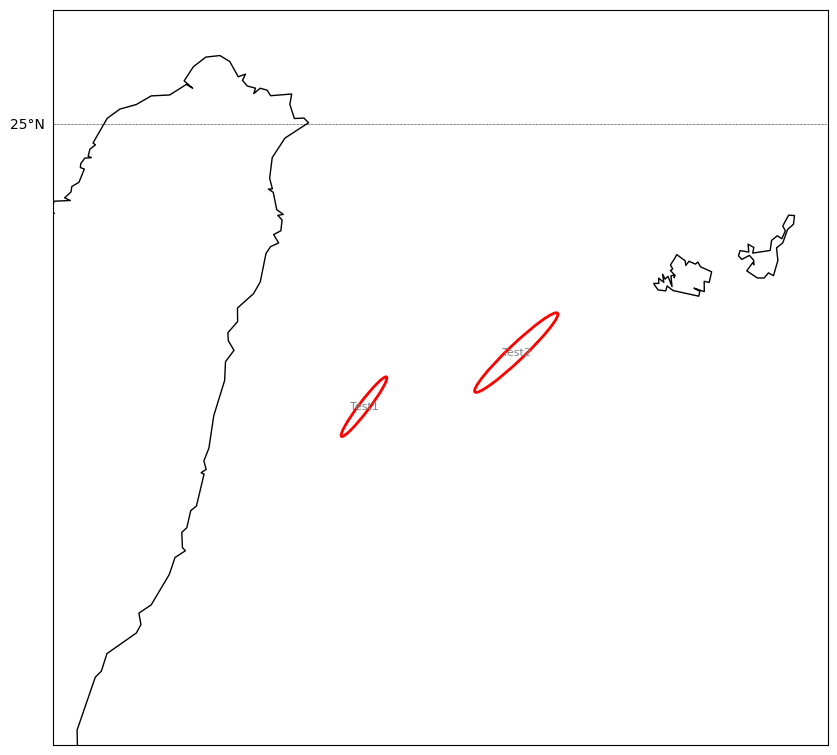

In [36]:
plot_ellipses_map(lon1, lat1, major1, minor1, inclination1, 
                  ['Test1', 'Test2'], 0.05, 1.5)

In [60]:
lon2, lat2, major2, minor2, inclination2, phase2 = get_tidal_ellipse_dataframe(dft, 'm2')

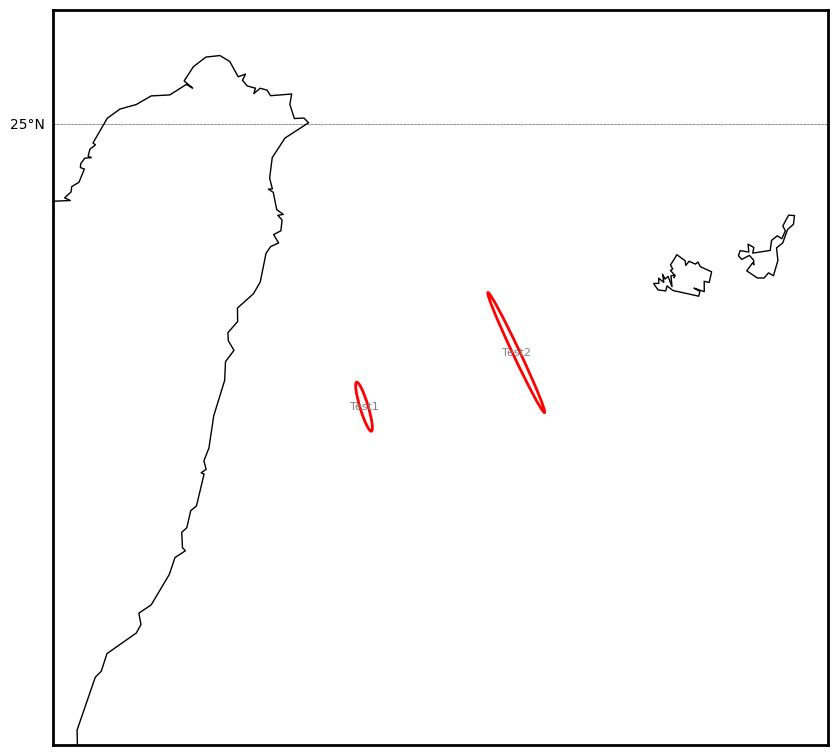

In [63]:
plot_ellipses_map(lon2, lat2, major2, minor2, inclination2, 
                  ['Test1', 'Test2'], 0.025, 1.5)

In [114]:
data_paper4 = {
    "Station": ["MT", "WC", "KM", "TS", "HC", "TC", "BD", "KS1", "PH1", "LY", "KS", "KT", "PH2", "CG", "JW", "DS", "HL", "GF", "BL"],
    "O1_amp": [24.15, 25.59, 25.57, 15.73, 19.09, 20.94, 21.62, 19.23, 20.92, 15.71, 15.91, 20.99, 21.03, 14.75, 18.68, 18.58, 14.07, 12.06, 19.70],
    "O1_ph": [80.7, 97.9, 105.8, 89.6, 91.7, 97.0, 111.1, 119.1, 110.9, 81.3, 130.0, 113.0, 127.3, 79.2, 99.0, 127.5, 81.6, 74.0, 124.5],
    "P1_amp": [9.71, 11.01, 11.22, 6.33, 7.78, 8.31, 6.81, 6.04, 7.01, 5.47, 5.78, 7.61, 7.69, 5.85, 7.16, 6.35, 5.30, 4.85, 7.22],
    "P1_ph": [112.8, 134.4, 143.8, 118.3, 131.8, 137.3, 143.7, 136.9, 146.7, 106.5, 158.2, 144.7, 156.9, 96.9, 122.2, 157.9, 100.6, 94.5, 155.9],
    "K1_amp": [31.99, 34.10, 34.16, 18.83, 24.53, 26.92, 28.15, 21.53, 25.91, 24.24, 17.19, 23.00, 24.19, 17.54, 22.05, 20.88, 15.69, 14.40, 22.69],
    "K1_ph": [115.0, 144.3, 152.0, 126.2, 131.5, 140.9, 144.6, 154.1, 152.7, 159.9, 167.0, 137.6, 160.1, 101.5, 126.0, 161.3, 98.8, 100.4, 157.8],
    "N2_amp": [35.25, 35.30, 31.63, 14.27, 28.49, 33.96, 13.48, 3.07, 15.61, 8.21, 4.02, 5.36, 16.18, 9.65, 23.09, 13.42, 8.57, 5.40, 20.37],
    "N2_ph": [141.1, 164.2, 185.2, 162.4, 162.2, 163.6, 154.1, 96.5, 164.9, 28.8, 342.3, 317.7, 74.9, 290.3, 61.23, 56.5, 295.7, 306.6, 64.4],
    "M2_amp": [203.78, 209.24, 179.08, 84.66, 162.67, 184.67, 71.52, 22.87, 84.86, 41.88, 6.73, 27.15, 90.09, 20.6, 121.43, 68.78, 44.20, 27.73, 104.91],
    "M2_ph": [61.1, 87.5, 106.1, 80.0, 80.1, 83.6, 67.2, 353.2, 81.0, 294.9, 353.1, 318.6, 95.41, 324.8, 82.7, 78.6, 302.6, 315.1, 86.7],
    "S2_amp": [64.94, 62.52, 54.05, 25.75, 48.70, 52.76, 16.59, 13.54, 21.70, 17.65, 3.37, 13.06, 23.29, 3.02, 34.89, 16.65, 19.82, 12.00, 27.91],
    "S2_ph": [84.6, 119.0, 144.4, 103.3, 113.3, 115.0, 107.9, 335.7, 123.5, 315.7, 105.7, 343.0, 137.4, 67.7, 115.0, 116.9, 325.1, 337.6, 125.8],
}

raw_data_paper4 = []
constituents = ["O1", "P1", "K1", "N2", "M2", "S2"]

for i, station in enumerate(data_paper4["Station"]):
    for constituent in constituents:
        raw_data_paper4.append({
            "Station": station,
            "type": "z",  # Assuming data is for 'u' component; adjust if needed
            "variable": "amplitude",
            "value": data_paper4[f"{constituent}_amp"][i],
            "constituents": constituent
            #"latitude": "",  # Placeholder; will be populated later
            #"longitude": ""  # Placeholder; will be populated later
        })
        
        raw_data_paper4.append({
            "Station": station,
            "type": "z",  # Assuming data is for 'u' component; adjust if needed
            "variable": "phase",
            "value": data_paper4[f"{constituent}_ph"][i],
            "constituents": constituent
            #"latitude": "",  # Placeholder; will be populated later
            #"longitude": ""  # Placeholder; will be populated later
        })

print(raw_data_paper4)

[{'Station': 'MT', 'type': 'z', 'variable': 'amplitude', 'value': 24.15, 'constituents': 'O1'}, {'Station': 'MT', 'type': 'z', 'variable': 'phase', 'value': 80.7, 'constituents': 'O1'}, {'Station': 'MT', 'type': 'z', 'variable': 'amplitude', 'value': 9.71, 'constituents': 'P1'}, {'Station': 'MT', 'type': 'z', 'variable': 'phase', 'value': 112.8, 'constituents': 'P1'}, {'Station': 'MT', 'type': 'z', 'variable': 'amplitude', 'value': 31.99, 'constituents': 'K1'}, {'Station': 'MT', 'type': 'z', 'variable': 'phase', 'value': 115.0, 'constituents': 'K1'}, {'Station': 'MT', 'type': 'z', 'variable': 'amplitude', 'value': 35.25, 'constituents': 'N2'}, {'Station': 'MT', 'type': 'z', 'variable': 'phase', 'value': 141.1, 'constituents': 'N2'}, {'Station': 'MT', 'type': 'z', 'variable': 'amplitude', 'value': 203.78, 'constituents': 'M2'}, {'Station': 'MT', 'type': 'z', 'variable': 'phase', 'value': 61.1, 'constituents': 'M2'}, {'Station': 'MT', 'type': 'z', 'variable': 'amplitude', 'value': 64.94,

In [173]:
print(paper3_df[["Location","Longitude","Latitude"]])

  Location   Longitude   Latitude
0      WC1  119.483333  24.983333
1      WC2  119.800000  24.833333
2      WC3  120.133333  24.650000
3      WC4  120.466667  24.466667
4      EWC  120.133333  25.000000
5      PHC  119.866667  23.850000


In [97]:
import requests
from bs4 import BeautifulSoup
#中央氣象署海象觀測站列表
url = 'https://oceanapi.cwb.gov.tw/restapi/v2/static/station/station_info.html'

response = requests.get(url)
soup = BeautifulSoup(response.content, 'html.parser')

# should be the first table on webpage
table = soup.find('table')

headers = [td.text.strip() for td in table.find_all('tr')[3].find_all('td')]
idx_st_tw = headers.index('站名')
idx_st_en = headers.index('英文站名')
idx_lon = headers.index('經度')
idx_lat = headers.index('緯度')
print(headers, idx_st_tw, idx_st_en, idx_lon, idx_lat)

data4 = []

for row in table.find_all('tr')[4:]:
    columns = row.find_all('td')
    if len(columns) >= idx_lat-1:
        lonx = columns[idx_lon].text.strip()
        latx = columns[idx_lat].text.strip()
        if lonx and latx:
            lon = float(lonx) #if columns[idx_lon].text.strip() else None
            lat = float(latx) #if columns[idx_lat].text.strip() else None
            st_tw = columns[idx_st_tw].text.strip()
            station = columns[idx_st_en].text.strip()

            data4.append({
              'Longitude': lon,
              'Latitude': lat,
              'Location': station,
              'st_tw': st_tw,
            })
        else:
            continue    
    else:
      continue 



['現行站碼', '未來新站碼', '站名', '英文站名', '觀測項目', '資料起始日期', '資料結束日期', '縣市', '鄉鎮', '位置', '經度', '緯度', '備註', '', ''] 2 3 10 11


In [109]:
loc_df = pd.DataFrame(data4)
print(loc_df)

     Longitude   Latitude                 Location    st_tw
0   121.424720  25.175550                   Tamsui       淡水
1   121.917770  25.097220                 Longdong       龍洞
2   121.510270  25.283880                Linshanbi      麟山鼻
3   121.369720  25.160000              Taipei Port      臺北港
4   121.949720  25.021380                   Fulong       福隆
5   121.407500  25.183900                   Danhai       淡海
6   121.752220  25.155000                  Keelung       基隆
7   122.076940  25.625000                Pengjiayu      彭佳嶼
8   121.799720  25.140270               ZhangTanLi      長潭里
9   121.243333  25.118050                   Zhuwei       竹圍
10  120.920550  24.848610                  Hsinchu       新竹
11  120.771110  24.651380                    Waipu       外埔
12  120.531380  24.287500            Taichung Port      臺中港
13  120.420270  24.084720                   Lukang       鹿港
14  120.137500  23.618610                 Boziliao      萡子寮
15  120.120000  23.470270               

In [92]:
#print(loc_df["Location"][24:])


24                  Chenggong
25                    Hualien
26                      Su-ao
27                      Wushi
28                      Matsu
29                     Penghu
30                      Cimei
31                      JiBei
32              Dongji Island
33              Longdong Buoy
34               Hualien Buoy
35            Guishandao Buoy
36           Xiao Liuqiu Buoy
37            Dapeng Bay buoy
38               Hsinchu Buoy
39            Fugui Cape Buoy
40             Pengjiayu Buoy
41              Taichung Buoy
42    Taitung Open Ocean Buoy
43                 Lanyu Buoy
44                Pratas Buoy
45                 Matsu Buoy
46                 Chimi Buoy
47                 Cheng-Kung
48              Dongji Island
Name: Location, dtype: object


In [93]:
#print(loc_df["st_tw"][24:])

24         成功
25         花蓮
26         蘇澳
27         烏石
28         馬祖
29       澎湖馬公
30         七美
31         吉貝
32        東吉島
33       龍洞浮標
34       花蓮浮標
35      龜山島浮標
36      小琉球浮標
37      大鵬灣浮標
38       新竹浮標
39    富貴角資料浮標
40    彭佳嶼資料浮標
41     臺中資料浮標
42     臺東外洋浮標
43       蘭嶼浮標
44      東沙島浮標
45       馬祖浮標
46       七美浮標
47       成功浮球
48     東吉島波浪站
Name: st_tw, dtype: object


In [136]:
print(paper2_df[["Location","Longitude","Latitude"]])

     Location   Longitude   Latitude
0       Matsu  119.950000  26.166667
1      Wuchou  119.450000  24.983333
2      Kinmen  118.416667  24.400000
3   Taipower1  121.600000  25.300000
4     Tamsuei  121.400000  25.183333
5     Hsinchu  120.916667  24.850000
6    Taichung  120.550000  24.333333
7       Budai  120.150000  23.383333
8      Dongee  119.666667  23.250000
9   Kaohsiung  120.283333  22.616667
10  Taipower3  120.750000  21.950000


In [138]:
#abbr to correspond 
abbr_to_location = {
    "MT": "Matsu",
    "WC": "Wuchou",
    "KM": "Kinmen", #資料浮標 東經118.4153度 北緯24.3797度 #https://www.cwa.gov.tw/V8/C/M/OBS_Marine.html?page=0&seas=OSea15
    "P1": "Taipower1",
    "TS": "Tamsuei",
    "HC": "Hsinchu",
    "TC": "Taichung",
    "BD": "Budai",     #120.115671, 23.373538 #https://wwtf.twport.com.tw/twport/display/Realtime_Panel_Port.html?10
    "DG": "Dongee",
    "KS": "Kaohsiung",
    "P3": "Taipower3",
    "LD": "Longdong",
    "HL": "Hualien",
    "CG": "Chenggong",
    "LY": "Lanyu",
    "KT": "Kenting", #120°49'22"E 21°54'08"N = 120.82277, 21.90222 https://www.namr.gov.tw/ebook/1100517/Current/files/basic-html/page28.html
    "DS": "Dongshi",
    "BL": "Boziliao",
    "MG": "Penghu",  #馬公
    "PH": "PHC", #unknown but equal PHC in another Jen's paper: 23D51' 119D52'
    "GF": "", #unknown
    "JW": "Zhuwei" 
}

In [139]:
data_paper4 = pd.DataFrame(raw_data_paper4)
print(data_paper4)

    Station type   variable   value constituents
0        MT    z  amplitude   24.15           O1
1        MT    z      phase   80.70           O1
2        MT    z  amplitude    9.71           P1
3        MT    z      phase  112.80           P1
4        MT    z  amplitude   31.99           K1
..      ...  ...        ...     ...          ...
223      BL    z      phase   64.40           N2
224      BL    z  amplitude  104.91           M2
225      BL    z      phase   86.70           M2
226      BL    z  amplitude   27.91           S2
227      BL    z      phase  125.80           S2

[228 rows x 5 columns]


In [140]:
# Convert abbreviation to full location name
data_paper4['Location'] = data_paper4['Station'].map(abbr_to_location)

# Merge data_paper3 with loc_df to get the longitude and latitude
merged_df = pd.merge(data_paper4, loc_df, on='Location', how='left')

# If you want to replace the original data_paper3 dataframe with the merged data
data_paper4 = merged_df

# To view the updated dataframe
print(data_paper4)

    Station type   variable   value constituents  Location  Longitude  \
0        MT    z  amplitude   24.15           O1     Matsu   119.9425   
1        MT    z      phase   80.70           O1     Matsu   119.9425   
2        MT    z  amplitude    9.71           P1     Matsu   119.9425   
3        MT    z      phase  112.80           P1     Matsu   119.9425   
4        MT    z  amplitude   31.99           K1     Matsu   119.9425   
..      ...  ...        ...     ...          ...       ...        ...   
223      BL    z      phase   64.40           N2  Boziliao   120.1375   
224      BL    z  amplitude  104.91           M2  Boziliao   120.1375   
225      BL    z      phase   86.70           M2  Boziliao   120.1375   
226      BL    z  amplitude   27.91           S2  Boziliao   120.1375   
227      BL    z      phase  125.80           S2  Boziliao   120.1375   

     Latitude st_tw  
0    26.16166    馬祖  
1    26.16166    馬祖  
2    26.16166    馬祖  
3    26.16166    馬祖  
4    26.16166

In [141]:
print(data_paper4[["Location","Longitude","Latitude", "variable", "value"]])

     Location  Longitude  Latitude   variable   value
0       Matsu   119.9425  26.16166  amplitude   24.15
1       Matsu   119.9425  26.16166      phase   80.70
2       Matsu   119.9425  26.16166  amplitude    9.71
3       Matsu   119.9425  26.16166      phase  112.80
4       Matsu   119.9425  26.16166  amplitude   31.99
..        ...        ...       ...        ...     ...
223  Boziliao   120.1375  23.61861      phase   64.40
224  Boziliao   120.1375  23.61861  amplitude  104.91
225  Boziliao   120.1375  23.61861      phase   86.70
226  Boziliao   120.1375  23.61861  amplitude   27.91
227  Boziliao   120.1375  23.61861      phase  125.80

[228 rows x 5 columns]


In [145]:
missing_values = data_paper4[data_paper4['Longitude'].isna() | data_paper4['Latitude'].isna()]
print(missing_values)

    Station type   variable   value constituents Location  Longitude  \
84      KS1    z  amplitude   19.23           O1      NaN        NaN   
85      KS1    z      phase  119.10           O1      NaN        NaN   
86      KS1    z  amplitude    6.04           P1      NaN        NaN   
87      KS1    z      phase  136.90           P1      NaN        NaN   
88      KS1    z  amplitude   21.53           K1      NaN        NaN   
89      KS1    z      phase  154.10           K1      NaN        NaN   
90      KS1    z  amplitude    3.07           N2      NaN        NaN   
91      KS1    z      phase   96.50           N2      NaN        NaN   
92      KS1    z  amplitude   22.87           M2      NaN        NaN   
93      KS1    z      phase  353.20           M2      NaN        NaN   
94      KS1    z  amplitude   13.54           S2      NaN        NaN   
95      KS1    z      phase  335.70           S2      NaN        NaN   
96      PH1    z  amplitude   20.92           O1      NaN       

In [146]:
print(missing_values.groupby('Station')[['Longitude', 'Latitude']].mean())


         Longitude  Latitude
Station                     
GF             NaN       NaN
KS1            NaN       NaN
PH1            NaN       NaN
PH2            NaN       NaN


In [144]:
#     Location   Longitude   Latitude
#0       Matsu  119.950000  26.166667
#1      Wuchou  119.450000  24.983333
#2      Kinmen  118.416667  24.400000
#3   Taipower1  121.600000  25.300000
#4     Tamsuei  121.400000  25.183333
#5     Hsinchu  120.916667  24.850000
#6    Taichung  120.550000  24.333333
#7       Budai  120.150000  23.383333
##8      Dongee  119.666667  23.250000
#9   Kaohsiung  120.283333  22.616667
#10  Taipower3  120.750000  21.950000
#for index, row in missing_values.iterrows():
#    station = row['Station']
data_paper4.loc[(data_paper4['Station'] == 'BD'), 'Longitude'] = 120.150000
data_paper4.loc[(data_paper4['Station'] == 'BD'), 'Latitude'] = 23.383333
data_paper4.loc[(data_paper4['Station'] == 'KT'), 'Longitude'] = 120.82277
data_paper4.loc[(data_paper4['Station'] == 'KT'), 'Latitude'] = 21.90222
data_paper4.loc[(data_paper4['Station'] == 'KM'), 'Longitude'] = 118.416667
data_paper4.loc[(data_paper4['Station'] == 'KM'), 'Latitude'] = 24.400000
data_paper4.loc[(data_paper4['Station'] == 'TS'), 'Longitude'] = 121.400000
data_paper4.loc[(data_paper4['Station'] == 'TS'), 'Latitude'] = 25.183333
data_paper4.loc[(data_paper4['Station'] == 'WC'), 'Longitude'] = 119.450000
data_paper4.loc[(data_paper4['Station'] == 'WC'), 'Latitude'] = 24.983333
data_paper4.loc[(data_paper4['Station'] == 'TC'), 'Longitude'] = 120.550000
data_paper4.loc[(data_paper4['Station'] == 'TC'), 'Latitude'] = 24.333333

In [154]:
paper4_df = data_paper4.dropna(subset=['Longitude', 'Latitude'])
print(paper4_df)

    Station type   variable   value constituents  Location  Longitude  \
0        MT    z  amplitude   24.15           O1     Matsu   119.9425   
1        MT    z      phase   80.70           O1     Matsu   119.9425   
2        MT    z  amplitude    9.71           P1     Matsu   119.9425   
3        MT    z      phase  112.80           P1     Matsu   119.9425   
4        MT    z  amplitude   31.99           K1     Matsu   119.9425   
..      ...  ...        ...     ...          ...       ...        ...   
223      BL    z      phase   64.40           N2  Boziliao   120.1375   
224      BL    z  amplitude  104.91           M2  Boziliao   120.1375   
225      BL    z      phase   86.70           M2  Boziliao   120.1375   
226      BL    z  amplitude   27.91           S2  Boziliao   120.1375   
227      BL    z      phase  125.80           S2  Boziliao   120.1375   

     Latitude st_tw combined_var  
0    26.16166    馬祖        O1_am  
1    26.16166    馬祖        O1_ph  
2    26.16166    馬

In [149]:
#zarr4_df = paper4_df.apply(lambda row: extract_from_zarr(row['Longitude'], row['Latitude'], dz), axis=1, result_type='expand')
#print(zarr4_df)

       M2_amp      M2_ph    S2_amp       S2_ph    N2_amp      N2_ph    K1_amp  \
0    2.094973  66.212455  0.659831   96.177171  0.389616  44.896015  0.308974   
1    2.094973  66.212455  0.659831   96.177171  0.389616  44.896015  0.308974   
2    2.094973  66.212455  0.659831   96.177171  0.389616  44.896015  0.308974   
3    2.094973  66.212455  0.659831   96.177171  0.389616  44.896015  0.308974   
4    2.094973  66.212455  0.659831   96.177171  0.389616  44.896015  0.308974   
..        ...        ...       ...         ...       ...        ...       ...   
223  0.951955  84.151660  0.252448  120.730205  0.202608  52.621068  0.207509   
224  0.951955  84.151660  0.252448  120.730205  0.202608  52.621068  0.207509   
225  0.951955  84.151660  0.252448  120.730205  0.202608  52.621068  0.207509   
226  0.951955  84.151660  0.252448  120.730205  0.202608  52.621068  0.207509   
227  0.951955  84.151660  0.252448  120.730205  0.202608  52.621068  0.207509   

          K1_ph    O1_amp  

In [158]:
# Create a new column combining constituents and variable
data_paper4['combined_var'] = data_paper4['constituents'] + "_" + data_paper4['variable'].str[:2]

# Pivot the table
p4_wide = pd.pivot_table(data_paper4, values='value', index=['Location', 'Longitude', 'Latitude'], columns='combined_var', aggfunc='first').reset_index()


In [159]:
p4_wide.columns = p4_wide.columns.str.replace(r'^(.*)_am$', r'\1_amp', regex=True)
p4_wide.rename(columns = {'Longitude':'longitude', 'Latitude':'latitude'}, inplace = True)
print(p4_wide)

combined_var   Location   longitude   latitude  K1_amp  K1_ph  M2_amp  M2_ph  \
0              Boziliao  120.137500  23.618610   22.69  157.8  104.91   86.7   
1                 Budai  120.150000  23.383333   28.15  144.6   71.52   67.2   
2             Chenggong  121.380000  23.097222   17.54  101.5   20.60  324.8   
3               Dongshi  120.139160  23.450000   20.88  161.3   68.78   78.6   
4               Hsinchu  120.920550  24.848610   24.53  131.5  162.67   80.1   
5               Hualien  121.623610  23.980270   15.69   98.8   44.20  302.6   
6             Kaohsiung  120.288050  22.614440   17.19  167.0    6.73  353.1   
7               Kenting  120.822770  21.902220   23.00  137.6   27.15  318.6   
8                Kinmen  118.416667  24.400000   34.16  152.0  179.08  106.1   
9                 Lanyu  121.507770  22.057500   24.24  159.9   41.88  294.9   
10                Matsu  119.942500  26.161660   31.99  115.0  203.78   61.1   
11             Taichung  120.550000  24.

In [160]:
p4_wide.to_csv("./tmp_paper4_z.csv")

In [169]:
import io
data_u = """
Location O1_amp O1_ph P1_amp P1_ph K1_amp K1_ph N2_amp N2_ph M2_amp M2_ph S2_amp S2_ph
WC1 5.42 260.9 2.61 314.2 7.89 307.2 5.69 243.7 25.65 257.0 7.79 285.5
WC2 5.37 261.8 2.46 300.8 7.42 293.8 3.85 221.5 18.69 232.2 6.69 276.0
WC3 4.11 254.1 1.76 300.5 5.33 293.5 2.77 208.2 11.35 214.4 3.96 255.2
WC4 2.99 264.5 1.27 297.9 3.82 290.9 1.00 211.8 3.57 223.0 1.77 269.5
EWC 6.13 237.8 3.09 288.5 9.33 281.4 4.91 183.0 28.47 204.6 9.34 248.6
PHC 3.10 269.8 1.43 295.1 4.32 288.1 4.96 295.6 27.70 336.2 8.71 3.51
"""

data_v = """
Location O1_amp O1_ph P1_amp P1_ph K1_amp K1_ph N2_amp N2_ph M2_amp M2_ph S2_amp S2_ph
WC1 2.96 245.6 1.57 314.7 4.73 307.6 3.07 263.7 16.02 284.8 4.80 302.5
WC2 3.88 272.9 1.75 308.5 5.28 301.5 3.20 262.3 15.82 284.0 5.71 313.4
WC3 3.61 256.1 1.66 309.3 5.03 302.3 1.98 257.6 8.88 273.7 3.38 309.4
WC4 3.71 251.5 1.79 314.1 5.40 307.1 1.15 213.7 3.90 224.9 2.10 271.4
EWC 3.82 256.6 2.39 296.8 7.24 289.8 2.66 225.6 16.47 251.0 6.57 288.3
PHC 5.08 310.4 2.32 351.7 7.02 344.7 9.52 317.3 63.76 349.8 17.7 22.0
"""

# Convert the string data into dataframes
df_u = pd.merge(pd.read_table(io.StringIO(data_u), delim_whitespace=True), paper3_df[["Location","Longitude","Latitude"]], on=["Location"], how='left')
df_v = pd.merge(pd.read_table(io.StringIO(data_v), delim_whitespace=True), paper3_df[["Location","Longitude","Latitude"]], on=["Location"], how='left')
df_u["type"] = "u"
df_v["type"] = "v"
df_uv= pd.concat([df_u, df_v], ignore_index=True)
df_uv.rename(columns = {'Longitude':'longitude', 'Latitude':'latitude'}, inplace = True)
print(df_uv)

   Location  O1_amp  O1_ph  P1_amp  P1_ph  K1_amp  K1_ph  N2_amp  N2_ph  \
0       WC1    5.42  260.9    2.61  314.2    7.89  307.2    5.69  243.7   
1       WC2    5.37  261.8    2.46  300.8    7.42  293.8    3.85  221.5   
2       WC3    4.11  254.1    1.76  300.5    5.33  293.5    2.77  208.2   
3       WC4    2.99  264.5    1.27  297.9    3.82  290.9    1.00  211.8   
4       EWC    6.13  237.8    3.09  288.5    9.33  281.4    4.91  183.0   
5       PHC    3.10  269.8    1.43  295.1    4.32  288.1    4.96  295.6   
6       WC1    2.96  245.6    1.57  314.7    4.73  307.6    3.07  263.7   
7       WC2    3.88  272.9    1.75  308.5    5.28  301.5    3.20  262.3   
8       WC3    3.61  256.1    1.66  309.3    5.03  302.3    1.98  257.6   
9       WC4    3.71  251.5    1.79  314.1    5.40  307.1    1.15  213.7   
10      EWC    3.82  256.6    2.39  296.8    7.24  289.8    2.66  225.6   
11      PHC    5.08  310.4    2.32  351.7    7.02  344.7    9.52  317.3   

    M2_amp  M2_ph  S2_am

In [170]:
df_uv.to_csv("./tmp_paper4_uv.csv")
